In [1]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt
import copy

In [2]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3, anomaly=0):
    dt = 1.0
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    X[:, 0] = mu  # начальные условия
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1]) * dt + sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t] = X[:, t-1] + dX
        timeline[t] = dt + timeline[t-1]
    if anomaly:
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += np.random.choice([1, -1]) * anomaly # аномалия +- 5 сигм

    return X, timeline

In [3]:
def generate_sin_func(n_samples, n_periods, n_steps_in_period = 100, anomaly = False) :
    n_steps = n_periods * n_steps_in_period
    range_ = n_periods * 2 * np.pi    # range - длина генерации синуса
    dt = range_ / (n_steps)    # шаг по оси Ox
    timeline = np.zeros((n_steps))

    X = np.zeros((n_samples, n_steps))
    params = np.zeros((n_samples, 3))
    for i in range(0, n_samples):
        params[i][0] = np.random.rand()     # множитель синуса
        params[i][1] = 1      # множитель аргумента синуса. Стоит 1 чтобы период всегда был 2 пи
        params[i][2] = np.random.uniform(0, np.pi)  # сдвиг фазы

    for t in range(0, n_steps):
        X[:, t] = params[:, 0] * np.sin(dt * t * params[:, 1] + params[:, 2])
        timeline[t] = dt * t
    if (anomaly) :
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] = np.random.choice([1, -1]) * params[sample, 0]  # аномалия равная макс/мин знач. синуса

    return X, timeline


In [4]:
def generate_linear_func(n_samples, n_steps, range_ = 1.0, stationary_window = 5, anomaly = False) :
    dt = range_ / n_steps
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    params = np.zeros((n_samples))
    for i in range(0, n_samples):
        params[i] = np.random.rand()  # коэффициент наклона
    cur_decr = 0
    for t in range(0, n_steps):
        X[:, t] = params[:] * t
        if (t % stationary_window == 0) :      # stationary window - как период у синуса, для стационаризации
            cur_decr = copy.deepcopy((X[:, t]))
        X[:, t] -= cur_decr
        timeline[t] = t
    if (anomaly) :
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += stationary_window * params[sample]  # аномалия + максимальное значение в "периоде"
    return X, timeline

Ornstein–Uhlenbeck Process

In [5]:
n_samples = 4
n_steps = 100
mu = 0.0
theta = 0.15
sigma = 0.3 
level = 2

In [6]:
# Ornstein–Uhlenbeck process without anomaly
X_noanomaly, timeline = generate_ou_process(4, 100, mu, theta, sigma, anomaly=0)

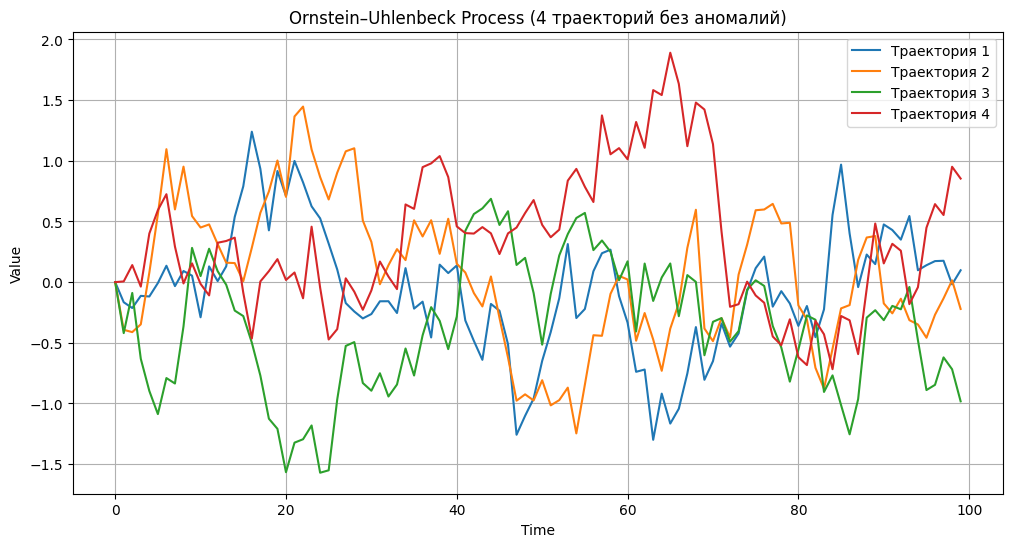

In [7]:
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(timeline, X_noanomaly[i, :], label=f"Траектория {i+1}")
plt.title("Ornstein–Uhlenbeck Process ({} траекторий без аномалий)".format(n_samples))
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
signatures_no_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
    signatures_no_anomaly.append(signature)
signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

In [9]:
iisignature.siglength(2, 2)

6

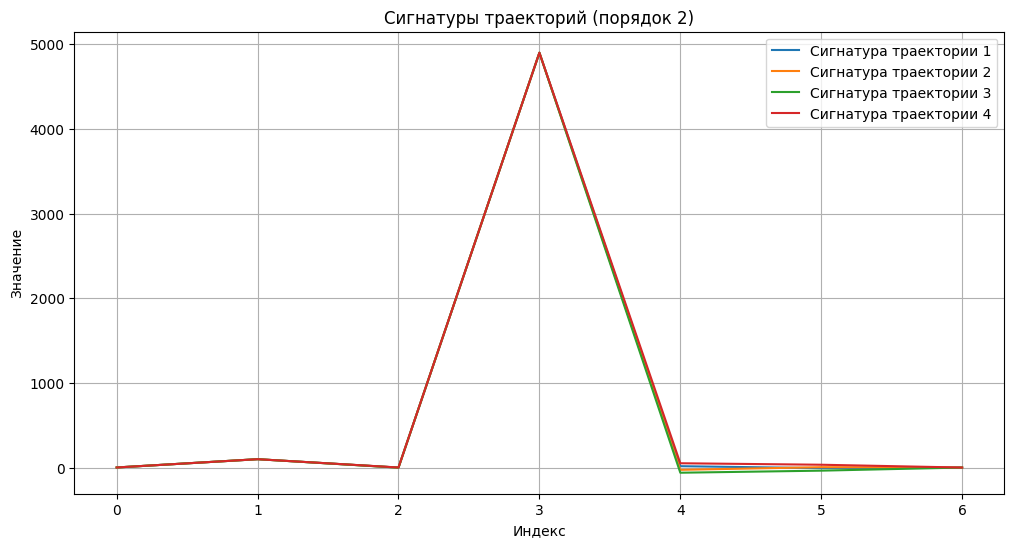

In [10]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Нормируем время

In [11]:
def normalize_arr(arr):
    arr = np.array(arr, dtype=float)
    mean = np.mean(arr)
    std_dev = np.std(arr)

    return (arr - mean) / std_dev

In [12]:
signatures_no_anomaly_normalized_time = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
    signatures_no_anomaly_normalized_time.append(signature)
signatures_no_anomaly_normalized_time = np.insert(signatures_no_anomaly_normalized_time, 0, 1, axis=1)

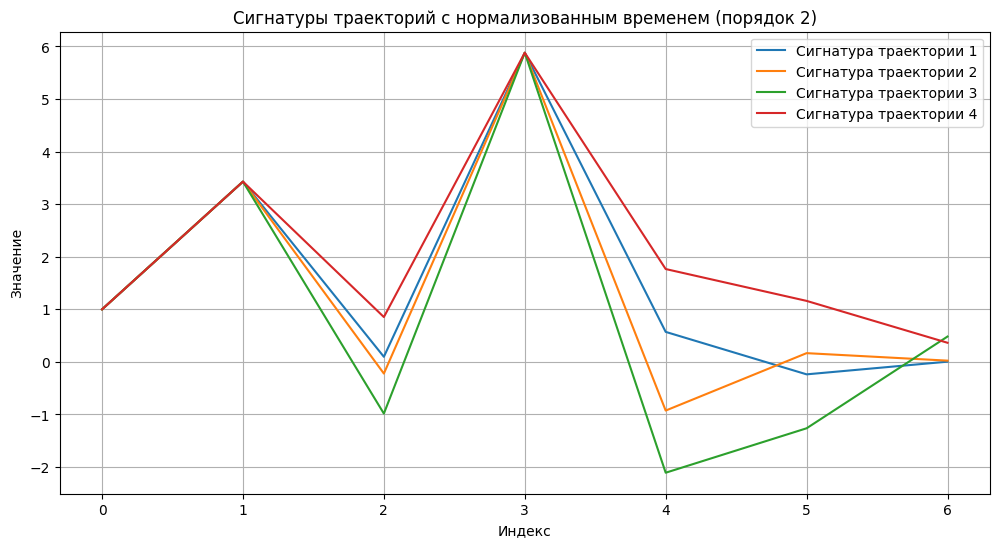

In [13]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly_normalized_time):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Нормирование времени снижает влияние на элементы сигнатуры, особенно на элементы, которые являются интегральными траекториями, созданными по первой координате траектории (времени), такие как S(X)^(1,1) S(X)^(1,1,1) и так далее 

Нормируем случайные величины процесса

In [14]:
signatures_no_anomaly_normalized_time_and_process = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), normalize_arr(X_noanomaly[i]))), level)
    signatures_no_anomaly_normalized_time_and_process.append(signature)
signatures_no_anomaly_normalized_time_and_process = np.insert(signatures_no_anomaly_normalized_time_and_process, 0, 1, axis=1)

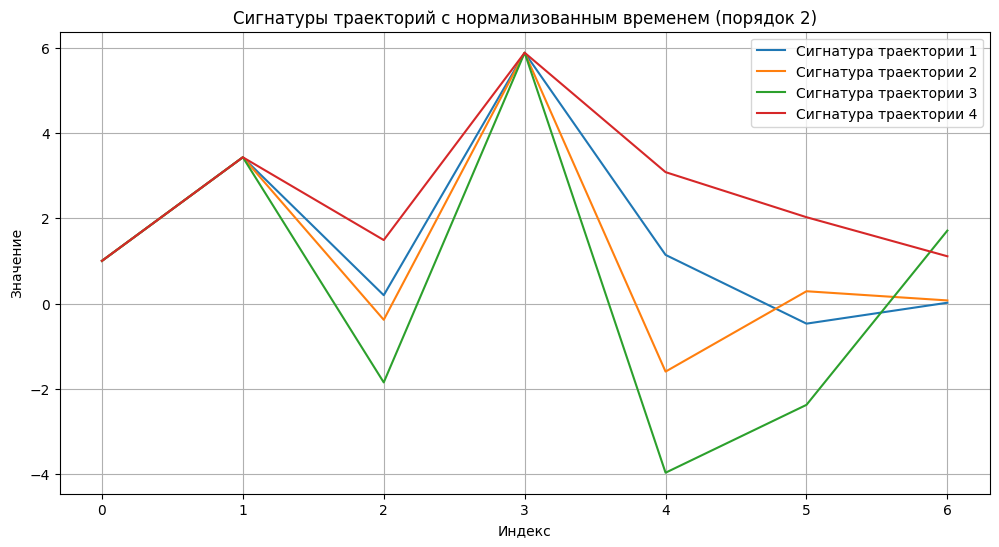

In [15]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly_normalized_time_and_process):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Изменений в масштабе нет, поэтому пока смысла нормировать все последовательности в траектории X = (X_time, X_ou) не вижу

Добавим аномалии в созданные процессы

In [16]:
def add_anomaly_to_random_vector(vectors, anomaly):
    random_index = np.random.randint(0, vectors.shape[0])
    vectors[random_index] += anomaly
    return vectors

In [17]:
# Ornstein–Uhlenbeck process with anomaly
X_anomaly = X_noanomaly.copy()
for i in range(n_samples):
    X_anomaly[i, :] = add_anomaly_to_random_vector(X_anomaly[i, :], np.random.choice([1, -1]) * 5)

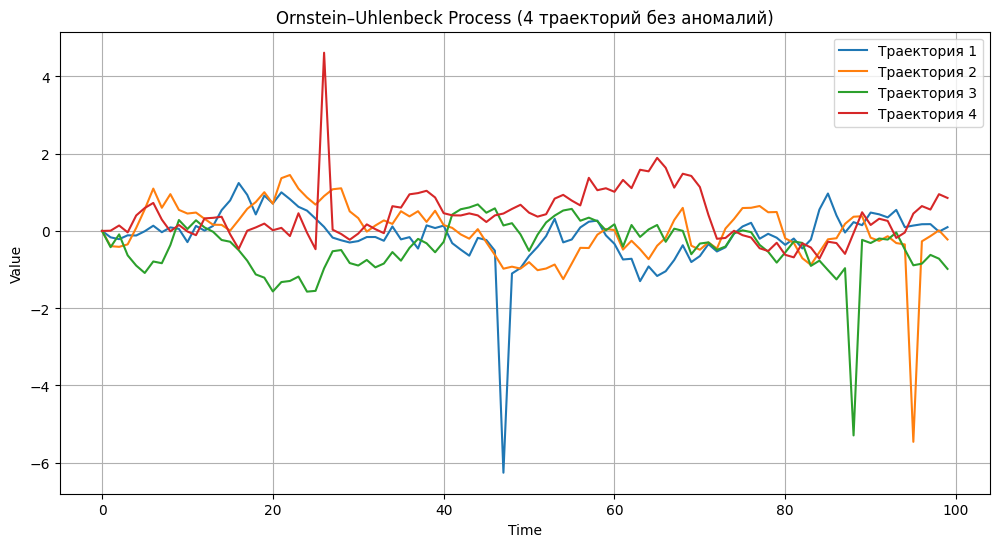

In [18]:
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(timeline, X_anomaly[i, :], label=f"Траектория {i+1}")
plt.title("Ornstein–Uhlenbeck Process ({} траекторий без аномалий)".format(n_samples))
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
signatures_with_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
    signatures_with_anomaly.append(signature)
signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

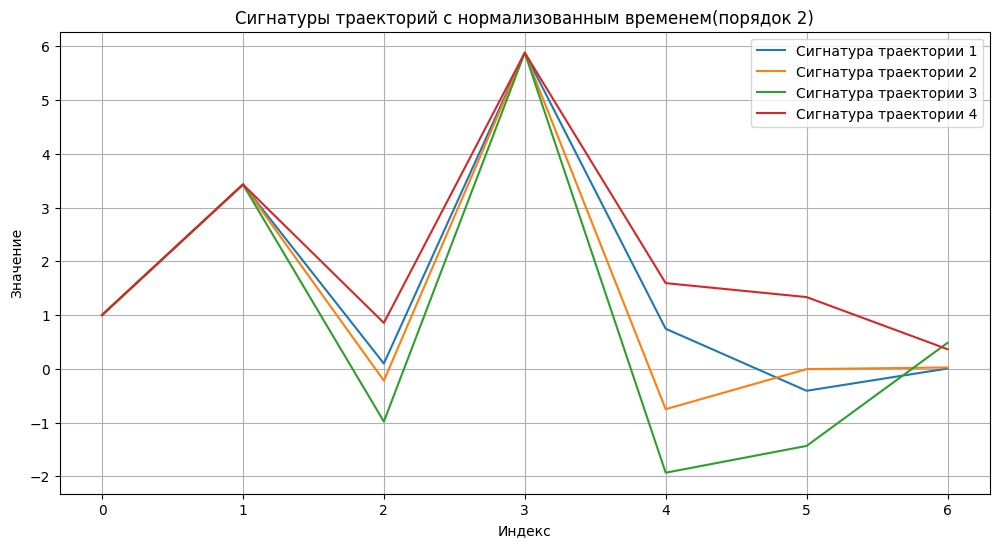

In [20]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_with_anomaly):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем(порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
signatures_no_anomaly = signatures_no_anomaly_normalized_time

In [22]:
diff_signatures = [signatures_no_anomaly[i] - signatures_with_anomaly[i] for i in range(len(signatures_with_anomaly))]
diff_signatures

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.73213742e-01,  1.73213742e-01,  1.11022302e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        -1.73213742e-01,  1.73213742e-01,  1.73819292e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -8.88178420e-16,  0.00000000e+00,
        -1.73213742e-01,  1.73213742e-01, -9.43689571e-16]),
 array([ 0.00000000e+00,  0.00000000e+00,  2.22044605e-16,  0.00000000e+00,
         1.73213742e-01, -1.73213742e-01,  1.94289029e-15])]

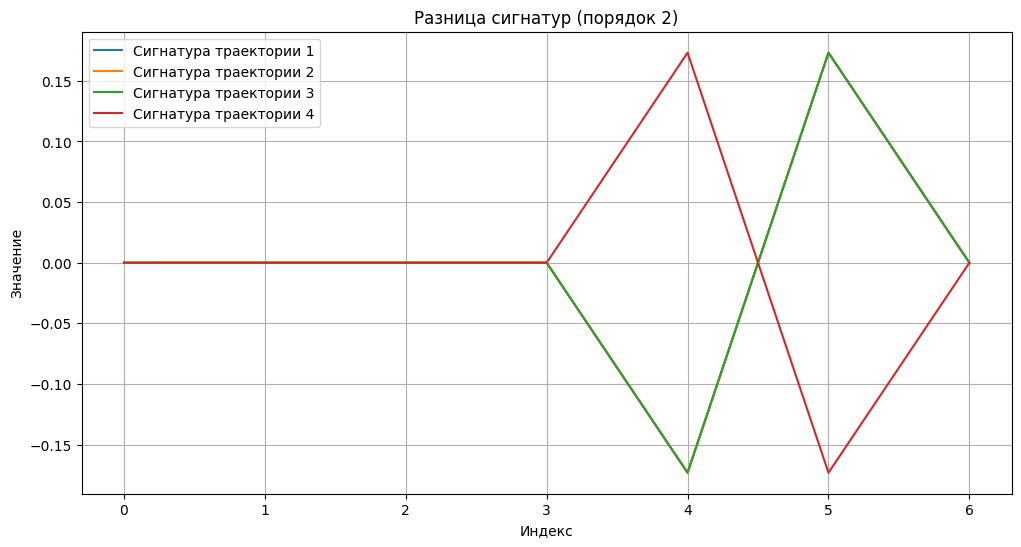

In [23]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(diff_signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Разница сигнатур (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Без нормализации времени

In [24]:
signatures_no_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
    signatures_no_anomaly.append(signature)
signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

In [25]:
signatures_with_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_anomaly[i])), level)
    signatures_with_anomaly.append(signature)
signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

In [26]:
diff_signatures = [signatures_no_anomaly[i] - signatures_with_anomaly[i] for i in range(len(signatures_with_anomaly))]
diff_signatures

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.00000000e+00,  5.00000000e+00,  1.11022302e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        -5.00000000e+00,  5.00000000e+00,  1.73819292e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -8.88178420e-16,  0.00000000e+00,
        -5.00000000e+00,  5.00000000e+00, -9.43689571e-16]),
 array([ 0.00000000e+00,  0.00000000e+00,  2.22044605e-16,  0.00000000e+00,
         5.00000000e+00, -5.00000000e+00,  1.94289029e-15])]

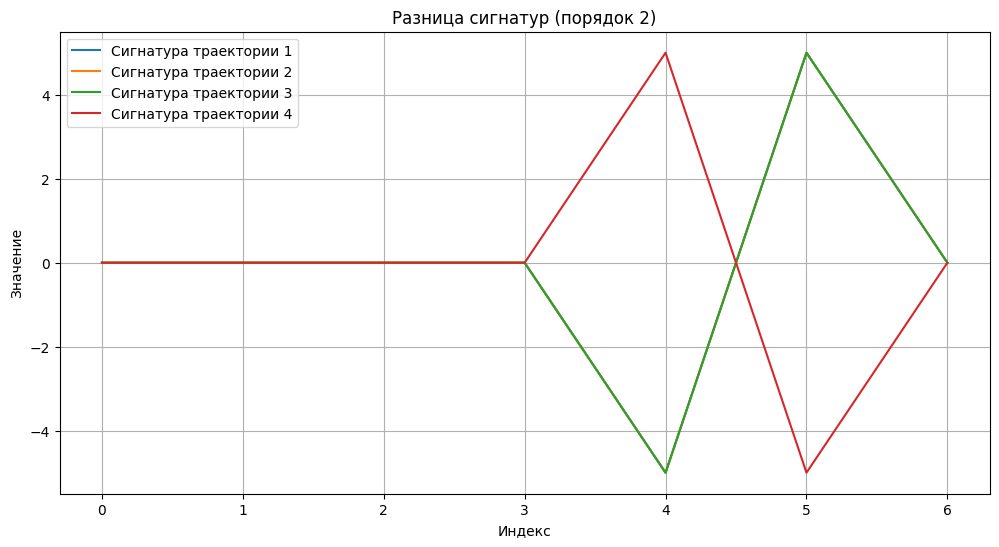

In [27]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(diff_signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Разница сигнатур (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Не видно влияния нормирования компоненты времени

Базовая модель обнаружения аномалий

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [40]:
np.random.seed(42)
torch.manual_seed(42)

In [41]:
def train_nn(model_params, X, y):
    n_samples = model_params["n_samples"]
    n_steps = model_params["n_steps"]
    num_epochs = model_params["num_epochs"]
    lr = model_params["lr"]
    batch_size = model_params["batch_size"]
    test_size = model_params["test_size"]
    hidden_size = model_params["hidden_size"]
    mu = model_params["mu"]
    theta = model_params["theta"]
    sigma = model_params["sigma"]
    anomaly_level = model_params["anomaly_level"]
    dimension = model_params["dimension"]
    level = model_params["level"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class ThreeLayerNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x

    input_size = X.shape[1]
    hidden_size = hidden_size
    output_size = 1
    model = ThreeLayerNN(input_size, hidden_size, output_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_epoch = 0
    best_loss = 10**10
    best_metrics = {}

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            all_outputs = []
            all_labels = []
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predicted = (outputs > 0.5).float()
                all_outputs.extend(outputs.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

            all_outputs = np.array(all_outputs).flatten()
            all_labels = np.array(all_labels).flatten()

            accuracy = 100 * (all_labels == (all_outputs > 0.5)).mean()
            precision = 100 * precision_score(all_labels, all_outputs > 0.5)
            recall = 100 * recall_score(all_labels, all_outputs > 0.5)
            f1 = 100 * f1_score(all_labels, all_outputs > 0.5)
            roc_auc = 100 * roc_auc_score(all_labels, all_outputs)
            conf_matrix = confusion_matrix(all_labels, all_outputs > 0.5)

            # Сохранение лучших метрик
            if best_loss > loss:
                best_epoch = epoch
                best_loss = loss
                best_metrics = {
                    "accuracy": accuracy,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1,
                    "roc_auc": roc_auc                }

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%, F1-score: {f1:.2f}")

    print(f"Минимум функции потерь на эпохе {best_epoch+1}, Accuracy: {best_metrics['accuracy']:.2f}%, Precision: {best_metrics['precision']:.2f}%, Recall: {best_metrics['recall']:.2f}%, F1-score: {best_metrics['f1_score']:.2f}%, Roc-auc: {best_metrics['roc_auc']:.2f}%")
    return best_metrics

Без использования сигнатур

In [42]:
model_params = {
    "n_samples": 1000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [43]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])

Размер процесса: 100
Epoch [1/20], Loss: 0.7182, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5530, Accuracy: 74.00%, F1-score: 23.53
Epoch [3/20], Loss: 0.5152, Accuracy: 73.00%, F1-score: 40.00
Epoch [4/20], Loss: 0.3926, Accuracy: 75.00%, F1-score: 51.92
Epoch [5/20], Loss: 0.2206, Accuracy: 77.50%, F1-score: 56.31
Epoch [6/20], Loss: 0.1620, Accuracy: 76.50%, F1-score: 59.13
Epoch [7/20], Loss: 0.0370, Accuracy: 82.00%, F1-score: 61.70
Epoch [8/20], Loss: 0.0134, Accuracy: 81.00%, F1-score: 57.78


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.0078, Accuracy: 81.50%, F1-score: 58.43
Epoch [10/20], Loss: 0.0054, Accuracy: 81.50%, F1-score: 59.34
Epoch [11/20], Loss: 0.0028, Accuracy: 81.50%, F1-score: 57.47
Epoch [12/20], Loss: 0.0025, Accuracy: 82.00%, F1-score: 59.09
Epoch [13/20], Loss: 0.0014, Accuracy: 81.50%, F1-score: 57.47
Epoch [14/20], Loss: 0.0013, Accuracy: 82.00%, F1-score: 59.09
Epoch [15/20], Loss: 0.0012, Accuracy: 82.00%, F1-score: 59.09
Epoch [16/20], Loss: 0.0012, Accuracy: 81.50%, F1-score: 57.47
Epoch [17/20], Loss: 0.0009, Accuracy: 81.50%, F1-score: 57.47
Epoch [18/20], Loss: 0.0007, Accuracy: 81.50%, F1-score: 57.47
Epoch [19/20], Loss: 0.0008, Accuracy: 81.50%, F1-score: 57.47
Epoch [20/20], Loss: 0.0005, Accuracy: 82.00%, F1-score: 58.14
Минимум функции потерь на эпохе 20, Accuracy: 82.00%, Precision: 96.15%, Recall: 41.67%, F1-score: 58.14%, Roc-auc: 83.80%
Размер процесса: 500
Epoch [1/20], Loss: 0.7226, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5028, Accuracy: 70

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.3168, Accuracy: 55.50%, F1-score: 21.24
Epoch [5/20], Loss: 0.1128, Accuracy: 60.50%, F1-score: 18.56
Epoch [6/20], Loss: 0.0181, Accuracy: 61.50%, F1-score: 18.95
Epoch [7/20], Loss: 0.0080, Accuracy: 59.50%, F1-score: 18.18
Epoch [8/20], Loss: 0.0912, Accuracy: 57.00%, F1-score: 17.31
Epoch [9/20], Loss: 0.0034, Accuracy: 60.50%, F1-score: 15.05
Epoch [10/20], Loss: 0.0041, Accuracy: 61.50%, F1-score: 17.20
Epoch [11/20], Loss: 0.0011, Accuracy: 59.00%, F1-score: 16.33
Epoch [12/20], Loss: 0.0028, Accuracy: 61.50%, F1-score: 15.38
Epoch [13/20], Loss: 0.0013, Accuracy: 56.50%, F1-score: 18.69
Epoch [14/20], Loss: 0.0008, Accuracy: 59.50%, F1-score: 18.18
Epoch [15/20], Loss: 0.0003, Accuracy: 60.00%, F1-score: 18.37
Epoch [16/20], Loss: 0.0004, Accuracy: 60.00%, F1-score: 18.37
Epoch [17/20], Loss: 0.0003, Accuracy: 61.00%, F1-score: 18.75
Epoch [18/20], Loss: 0.0002, Accuracy: 60.50%, F1-score: 18.56
Epoch [19/20], Loss: 0.0002, Accuracy: 60.50%, F1-score: 18.5

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.0058, Accuracy: 59.50%, F1-score: 28.32
Epoch [9/20], Loss: 0.0031, Accuracy: 61.00%, F1-score: 18.75
Epoch [10/20], Loss: 0.0016, Accuracy: 60.50%, F1-score: 23.30
Epoch [11/20], Loss: 0.0018, Accuracy: 62.00%, F1-score: 25.49
Epoch [12/20], Loss: 0.0012, Accuracy: 62.00%, F1-score: 24.00
Epoch [13/20], Loss: 0.0005, Accuracy: 62.50%, F1-score: 24.24
Epoch [14/20], Loss: 0.0002, Accuracy: 62.50%, F1-score: 24.24
Epoch [15/20], Loss: 0.0003, Accuracy: 62.50%, F1-score: 24.24
Epoch [16/20], Loss: 0.0002, Accuracy: 63.00%, F1-score: 24.49
Epoch [17/20], Loss: 0.0002, Accuracy: 63.00%, F1-score: 24.49
Epoch [18/20], Loss: 0.0002, Accuracy: 63.50%, F1-score: 26.26
Epoch [19/20], Loss: 0.0001, Accuracy: 63.50%, F1-score: 26.26
Epoch [20/20], Loss: 0.0002, Accuracy: 63.50%, F1-score: 27.72
Минимум функции потерь на эпохе 19, Accuracy: 63.50%, Precision: 33.33%, Recall: 21.67%, F1-score: 26.26%, Roc-auc: 46.39%
Размер процесса: 2500
Epoch [1/20], Loss: 0.7276, Accuracy: 

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.0047, Accuracy: 61.00%, F1-score: 22.00
Epoch [8/20], Loss: 0.0011, Accuracy: 59.50%, F1-score: 16.49
Epoch [9/20], Loss: 0.0003, Accuracy: 59.00%, F1-score: 16.33
Epoch [10/20], Loss: 0.0005, Accuracy: 59.00%, F1-score: 16.33
Epoch [11/20], Loss: 0.0003, Accuracy: 59.50%, F1-score: 16.49
Epoch [12/20], Loss: 0.0001, Accuracy: 58.50%, F1-score: 14.43
Epoch [13/20], Loss: 0.0004, Accuracy: 58.50%, F1-score: 14.43
Epoch [14/20], Loss: 0.0002, Accuracy: 58.50%, F1-score: 14.43
Epoch [15/20], Loss: 0.0001, Accuracy: 58.50%, F1-score: 14.43
Epoch [16/20], Loss: 0.0002, Accuracy: 58.50%, F1-score: 14.43
Epoch [17/20], Loss: 0.0001, Accuracy: 58.50%, F1-score: 14.43
Epoch [18/20], Loss: 0.0001, Accuracy: 59.00%, F1-score: 14.58
Epoch [19/20], Loss: 0.0001, Accuracy: 58.50%, F1-score: 14.43
Epoch [20/20], Loss: 0.0001, Accuracy: 58.50%, F1-score: 14.43
Минимум функции потерь на эпохе 17, Accuracy: 58.50%, Precision: 18.92%, Recall: 11.67%, F1-score: 14.43%, Roc-auc: 48.68

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.0008, Accuracy: 60.50%, F1-score: 27.52
Epoch [6/20], Loss: 0.0003, Accuracy: 61.00%, F1-score: 27.78
Epoch [7/20], Loss: 0.0002, Accuracy: 61.00%, F1-score: 27.78
Epoch [8/20], Loss: 0.0002, Accuracy: 61.00%, F1-score: 27.78
Epoch [9/20], Loss: 0.0002, Accuracy: 61.00%, F1-score: 27.78
Epoch [10/20], Loss: 0.0002, Accuracy: 61.00%, F1-score: 27.78
Epoch [11/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [12/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [13/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [14/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [15/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [16/20], Loss: 0.0000, Accuracy: 61.00%, F1-score: 27.78
Epoch [17/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [18/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.78
Epoch [19/20], Loss: 0.0000, Accuracy: 61.00%, F1-score: 27.78
Epoch [20/20], Loss: 0.0000, Accuracy: 61.00%, F1-score: 27.

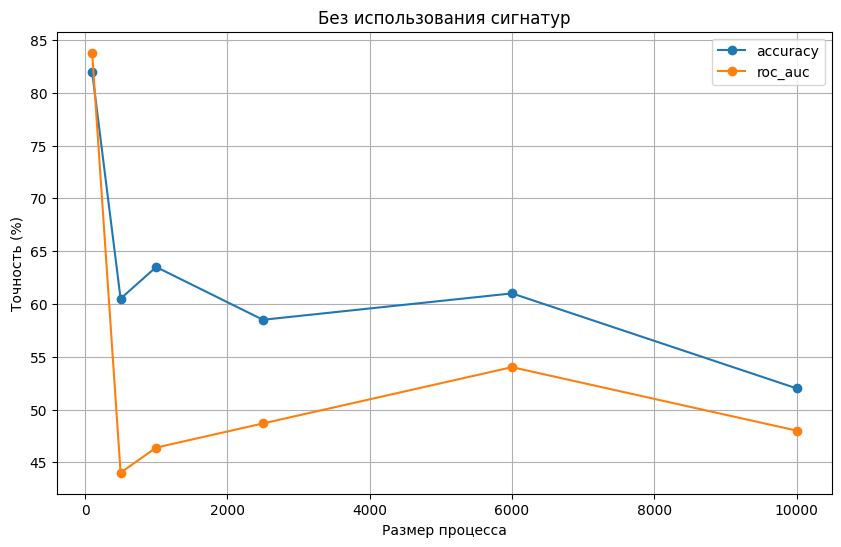

In [44]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=key)
plt.title("Без использования сигнатур")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

Увеличим размер выборки

In [45]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [46]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])


Размер процесса: 100
Epoch [1/20], Loss: 0.1718, Accuracy: 96.25%, F1-score: 93.48
Epoch [2/20], Loss: 0.0298, Accuracy: 98.80%, F1-score: 97.99
Epoch [3/20], Loss: 0.0161, Accuracy: 98.65%, F1-score: 97.75
Epoch [4/20], Loss: 0.0012, Accuracy: 99.65%, F1-score: 99.41
Epoch [5/20], Loss: 0.0004, Accuracy: 99.95%, F1-score: 99.92
Epoch [6/20], Loss: 0.0002, Accuracy: 99.95%, F1-score: 99.92
Epoch [7/20], Loss: 0.0003, Accuracy: 99.95%, F1-score: 99.92
Epoch [8/20], Loss: 0.0001, Accuracy: 99.95%, F1-score: 99.92
Epoch [9/20], Loss: 0.0001, Accuracy: 99.95%, F1-score: 99.92
Epoch [10/20], Loss: 0.0000, Accuracy: 99.95%, F1-score: 99.92
Epoch [11/20], Loss: 0.0001, Accuracy: 99.95%, F1-score: 99.92
Epoch [12/20], Loss: 0.0001, Accuracy: 99.95%, F1-score: 99.92
Epoch [13/20], Loss: 0.0001, Accuracy: 99.95%, F1-score: 99.92
Epoch [14/20], Loss: 0.0000, Accuracy: 99.95%, F1-score: 99.92
Epoch [15/20], Loss: 0.0000, Accuracy: 99.95%, F1-score: 99.92
Epoch [16/20], Loss: 0.0000, Accuracy: 99.9

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.7304, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6360, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/20], Loss: 0.4918, Accuracy: 70.10%, F1-score: 0.66
Epoch [4/20], Loss: 0.5359, Accuracy: 69.50%, F1-score: 4.98
Epoch [5/20], Loss: 0.6592, Accuracy: 64.00%, F1-score: 23.89
Epoch [6/20], Loss: 0.5311, Accuracy: 62.95%, F1-score: 23.69
Epoch [7/20], Loss: 0.3935, Accuracy: 62.00%, F1-score: 28.30
Epoch [8/20], Loss: 0.4380, Accuracy: 62.90%, F1-score: 26.68
Epoch [9/20], Loss: 0.2533, Accuracy: 62.30%, F1-score: 25.49
Epoch [10/20], Loss: 0.1797, Accuracy: 61.45%, F1-score: 27.47
Epoch [11/20], Loss: 0.0955, Accuracy: 63.40%, F1-score: 25.76
Epoch [12/20], Loss: 0.1208, Accuracy: 63.20%, F1-score: 27.84
Epoch [13/20], Loss: 0.1316, Accuracy: 64.35%, F1-score: 25.34
Epoch [14/20], Loss: 0.0565, Accuracy: 63.50%, F1-score: 26.85
Epoch [15/20], Loss: 0.0075, Accuracy: 63.95%, F1-score: 26.80
Epoch [16/20], Loss: 0.0155, Accuracy: 62.30%, F1-score: 24.90
Epoch [17/20], Loss: 0.0309, Accuracy: 62.65%, F1-score: 27.12
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6103, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5932, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/20], Loss: 0.5642, Accuracy: 68.85%, F1-score: 1.58
Epoch [4/20], Loss: 0.4893, Accuracy: 65.75%, F1-score: 14.48
Epoch [5/20], Loss: 0.4007, Accuracy: 63.30%, F1-score: 23.54
Epoch [6/20], Loss: 0.3928, Accuracy: 61.60%, F1-score: 22.27
Epoch [7/20], Loss: 0.1547, Accuracy: 59.10%, F1-score: 30.09
Epoch [8/20], Loss: 0.1202, Accuracy: 61.85%, F1-score: 28.89
Epoch [9/20], Loss: 0.0314, Accuracy: 60.85%, F1-score: 30.03
Epoch [10/20], Loss: 0.0601, Accuracy: 61.60%, F1-score: 27.41
Epoch [11/20], Loss: 0.0414, Accuracy: 60.20%, F1-score: 26.70
Epoch [12/20], Loss: 0.0526, Accuracy: 61.30%, F1-score: 28.73
Epoch [13/20], Loss: 0.0753, Accuracy: 61.10%, F1-score: 28.23
Epoch [14/20], Loss: 0.0194, Accuracy: 62.00%, F1-score: 28.03
Epoch [15/20], Loss: 0.0379, Accuracy: 62.75%, F1-score: 27.46
Epoch [16/20], Loss: 0.0167, Accuracy: 60.10%, F1-score: 29.13
Epoch [17/20], Loss: 0.1037, Accuracy: 59.80%, F1-score: 32.21
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.7005, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.6945, Accuracy: 69.95%, F1-score: 0.33
Epoch [3/20], Loss: 0.4682, Accuracy: 68.20%, F1-score: 9.40
Epoch [4/20], Loss: 0.3094, Accuracy: 59.80%, F1-score: 27.44
Epoch [5/20], Loss: 0.2758, Accuracy: 60.50%, F1-score: 27.26
Epoch [6/20], Loss: 0.0659, Accuracy: 57.45%, F1-score: 30.53
Epoch [7/20], Loss: 0.0479, Accuracy: 59.85%, F1-score: 26.67
Epoch [8/20], Loss: 0.1191, Accuracy: 57.60%, F1-score: 26.26
Epoch [9/20], Loss: 0.0279, Accuracy: 59.90%, F1-score: 26.42
Epoch [10/20], Loss: 0.0062, Accuracy: 59.85%, F1-score: 26.53
Epoch [11/20], Loss: 0.0446, Accuracy: 60.10%, F1-score: 24.72
Epoch [12/20], Loss: 0.0481, Accuracy: 59.10%, F1-score: 28.12
Epoch [13/20], Loss: 0.0072, Accuracy: 59.40%, F1-score: 27.37
Epoch [14/20], Loss: 0.0016, Accuracy: 59.50%, F1-score: 28.06
Epoch [15/20], Loss: 0.0001, Accuracy: 59.35%, F1-score: 27.35
Epoch [16/20], Loss: 0.0002, Accuracy: 59.35%, F1-score: 27.22
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5518, Accuracy: 69.25%, F1-score: 0.97
Epoch [3/20], Loss: 0.5469, Accuracy: 61.20%, F1-score: 25.53
Epoch [4/20], Loss: 0.4477, Accuracy: 56.15%, F1-score: 33.61
Epoch [5/20], Loss: 0.0809, Accuracy: 57.65%, F1-score: 28.40
Epoch [6/20], Loss: 0.0674, Accuracy: 57.45%, F1-score: 27.82
Epoch [7/20], Loss: 0.0244, Accuracy: 58.05%, F1-score: 30.72
Epoch [8/20], Loss: 0.0474, Accuracy: 57.85%, F1-score: 31.63
Epoch [9/20], Loss: 0.1594, Accuracy: 57.55%, F1-score: 30.12
Epoch [10/20], Loss: 0.0013, Accuracy: 56.00%, F1-score: 31.36
Epoch [11/20], Loss: 0.1405, Accuracy: 61.40%, F1-score: 24.61
Epoch [12/20], Loss: 0.0052, Accuracy: 59.50%, F1-score: 29.32
Epoch [13/20], Loss: 0.0442, Accuracy: 59.95%, F1-score: 26.85
Epoch [14/20], Loss: 0.2047, Accuracy: 58.80%, F1-score: 29.21
Epoch [15/20], Loss: 0.1141, Accuracy: 59.80%, F1-score: 30.81
Epoch [16/20], Loss: 0.1903, Accuracy: 60.40%, F1-score: 28.90
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6734, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.6779, Accuracy: 67.30%, F1-score: 11.62
Epoch [3/20], Loss: 0.4266, Accuracy: 59.95%, F1-score: 26.04
Epoch [4/20], Loss: 0.2009, Accuracy: 60.70%, F1-score: 26.40
Epoch [5/20], Loss: 0.2354, Accuracy: 61.70%, F1-score: 21.84
Epoch [6/20], Loss: 0.3496, Accuracy: 59.15%, F1-score: 25.93
Epoch [7/20], Loss: 0.0884, Accuracy: 56.55%, F1-score: 31.74
Epoch [8/20], Loss: 0.0236, Accuracy: 59.10%, F1-score: 26.83
Epoch [9/20], Loss: 0.0133, Accuracy: 60.00%, F1-score: 27.27
Epoch [10/20], Loss: 0.0058, Accuracy: 59.95%, F1-score: 25.76
Epoch [11/20], Loss: 0.0005, Accuracy: 62.00%, F1-score: 24.60
Epoch [12/20], Loss: 0.0047, Accuracy: 60.80%, F1-score: 25.62
Epoch [13/20], Loss: 0.0001, Accuracy: 61.10%, F1-score: 26.05
Epoch [14/20], Loss: 0.0001, Accuracy: 61.20%, F1-score: 25.95
Epoch [15/20], Loss: 0.0001, Accuracy: 61.30%, F1-score: 26.00
Epoch [16/20], Loss: 0.0000, Accuracy: 61.45%, F1-score: 26.08
Ep

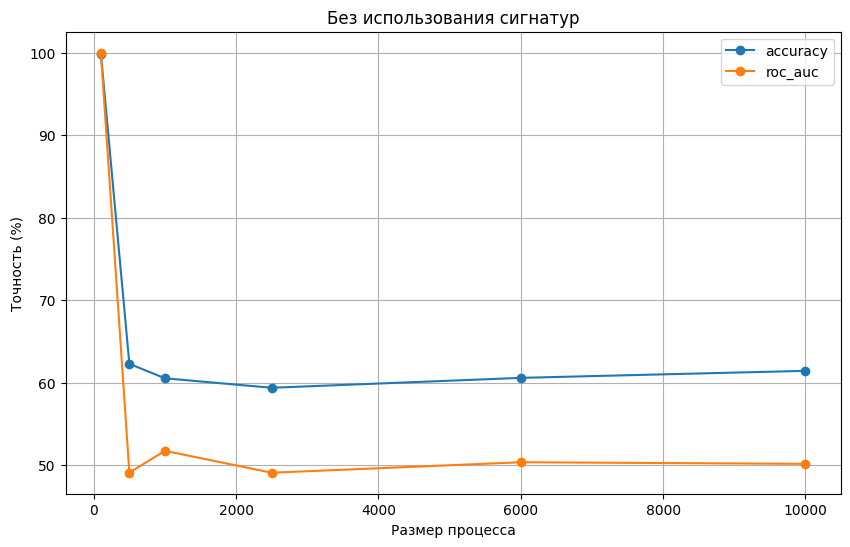

In [47]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=key)
plt.title("Без использования сигнатур")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

С сигнатурами/ сигнатура считается по всей траектории , без нормализации времени

In [48]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [49]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((timeline, X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])


Размер процесса: 100
Epoch [1/20], Loss: 0.0188, Accuracy: 98.45%, F1-score: 97.38
Epoch [2/20], Loss: 0.0148, Accuracy: 98.15%, F1-score: 96.91
Epoch [3/20], Loss: 0.0008, Accuracy: 99.65%, F1-score: 99.41
Epoch [4/20], Loss: 0.0006, Accuracy: 99.65%, F1-score: 99.42
Epoch [5/20], Loss: 0.0203, Accuracy: 98.20%, F1-score: 97.06
Epoch [6/20], Loss: 0.0115, Accuracy: 99.75%, F1-score: 99.58
Epoch [7/20], Loss: 0.0002, Accuracy: 99.80%, F1-score: 99.67
Epoch [8/20], Loss: 0.0003, Accuracy: 99.75%, F1-score: 99.58
Epoch [9/20], Loss: 0.0001, Accuracy: 99.75%, F1-score: 99.58
Epoch [10/20], Loss: 0.0002, Accuracy: 99.70%, F1-score: 99.50
Epoch [11/20], Loss: 0.0000, Accuracy: 99.75%, F1-score: 99.58
Epoch [12/20], Loss: 0.0001, Accuracy: 99.75%, F1-score: 99.58
Epoch [13/20], Loss: 0.0001, Accuracy: 99.75%, F1-score: 99.58
Epoch [14/20], Loss: 0.0000, Accuracy: 99.70%, F1-score: 99.50
Epoch [15/20], Loss: 0.0000, Accuracy: 99.70%, F1-score: 99.50
Epoch [16/20], Loss: 0.0000, Accuracy: 99.7

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6135, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6480, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/20], Loss: 0.6330, Accuracy: 69.60%, F1-score: 1.62
Epoch [4/20], Loss: 0.5813, Accuracy: 67.35%, F1-score: 13.05
Epoch [5/20], Loss: 0.6765, Accuracy: 65.30%, F1-score: 21.32
Epoch [6/20], Loss: 0.4370, Accuracy: 62.65%, F1-score: 24.01
Epoch [7/20], Loss: 0.4552, Accuracy: 62.25%, F1-score: 26.34
Epoch [8/20], Loss: 0.3562, Accuracy: 61.75%, F1-score: 28.30
Epoch [9/20], Loss: 0.2044, Accuracy: 58.15%, F1-score: 31.67
Epoch [10/20], Loss: 0.1266, Accuracy: 63.20%, F1-score: 28.68
Epoch [11/20], Loss: 0.0634, Accuracy: 62.55%, F1-score: 27.63
Epoch [12/20], Loss: 0.0597, Accuracy: 61.65%, F1-score: 29.05
Epoch [13/20], Loss: 0.0364, Accuracy: 58.50%, F1-score: 30.72
Epoch [14/20], Loss: 0.0967, Accuracy: 63.60%, F1-score: 27.78
Epoch [15/20], Loss: 0.0426, Accuracy: 60.40%, F1-score: 31.25
Epoch [16/20], Loss: 0.1751, Accuracy: 60.60%, F1-score: 32.42
Epoch [17/20], Loss: 0.0166, Accuracy: 63.85%, F1-score: 29.05
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6058, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5340, Accuracy: 69.45%, F1-score: 2.24
Epoch [3/20], Loss: 0.7215, Accuracy: 69.75%, F1-score: 1.63
Epoch [4/20], Loss: 0.4703, Accuracy: 65.55%, F1-score: 16.28
Epoch [5/20], Loss: 0.3848, Accuracy: 62.40%, F1-score: 25.25
Epoch [6/20], Loss: 0.3335, Accuracy: 61.40%, F1-score: 28.91
Epoch [7/20], Loss: 0.2800, Accuracy: 63.95%, F1-score: 30.20
Epoch [8/20], Loss: 0.1076, Accuracy: 60.30%, F1-score: 32.94
Epoch [9/20], Loss: 0.1385, Accuracy: 61.65%, F1-score: 28.65
Epoch [10/20], Loss: 0.2138, Accuracy: 62.50%, F1-score: 30.43
Epoch [11/20], Loss: 0.1134, Accuracy: 62.35%, F1-score: 30.21
Epoch [12/20], Loss: 0.2068, Accuracy: 61.65%, F1-score: 30.08
Epoch [13/20], Loss: 0.0350, Accuracy: 63.80%, F1-score: 24.90
Epoch [14/20], Loss: 0.0187, Accuracy: 63.95%, F1-score: 27.54
Epoch [15/20], Loss: 0.0161, Accuracy: 60.95%, F1-score: 32.15
Epoch [16/20], Loss: 0.0023, Accuracy: 61.80%, F1-score: 29.39
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6079, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.6788, Accuracy: 69.80%, F1-score: 0.98
Epoch [3/20], Loss: 0.4614, Accuracy: 63.75%, F1-score: 20.07
Epoch [4/20], Loss: 0.4861, Accuracy: 64.20%, F1-score: 18.64
Epoch [5/20], Loss: 0.1101, Accuracy: 60.75%, F1-score: 25.02
Epoch [6/20], Loss: 0.0833, Accuracy: 58.45%, F1-score: 28.55
Epoch [7/20], Loss: 0.0270, Accuracy: 59.80%, F1-score: 23.43
Epoch [8/20], Loss: 0.0404, Accuracy: 58.45%, F1-score: 29.04
Epoch [9/20], Loss: 0.0197, Accuracy: 58.85%, F1-score: 24.15
Epoch [10/20], Loss: 0.3243, Accuracy: 58.25%, F1-score: 29.06
Epoch [11/20], Loss: 0.0585, Accuracy: 61.55%, F1-score: 25.70
Epoch [12/20], Loss: 0.0664, Accuracy: 59.45%, F1-score: 27.26
Epoch [13/20], Loss: 0.0299, Accuracy: 58.95%, F1-score: 24.19
Epoch [14/20], Loss: 0.0024, Accuracy: 59.05%, F1-score: 25.34
Epoch [15/20], Loss: 0.0117, Accuracy: 59.90%, F1-score: 26.01
Epoch [16/20], Loss: 0.0051, Accuracy: 60.75%, F1-score: 19.82
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.8466, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.7557, Accuracy: 69.65%, F1-score: 2.57
Epoch [3/20], Loss: 0.6037, Accuracy: 63.30%, F1-score: 24.49
Epoch [4/20], Loss: 0.7181, Accuracy: 60.25%, F1-score: 28.31
Epoch [5/20], Loss: 0.1239, Accuracy: 58.65%, F1-score: 28.02
Epoch [6/20], Loss: 0.1707, Accuracy: 60.10%, F1-score: 25.42
Epoch [7/20], Loss: 0.0042, Accuracy: 62.35%, F1-score: 26.10
Epoch [8/20], Loss: 0.0214, Accuracy: 62.45%, F1-score: 25.86
Epoch [9/20], Loss: 0.0627, Accuracy: 59.25%, F1-score: 27.30
Epoch [10/20], Loss: 0.0471, Accuracy: 59.50%, F1-score: 24.16
Epoch [11/20], Loss: 0.0074, Accuracy: 57.50%, F1-score: 31.34
Epoch [12/20], Loss: 0.0007, Accuracy: 60.05%, F1-score: 25.54
Epoch [13/20], Loss: 0.0294, Accuracy: 61.15%, F1-score: 25.79
Epoch [14/20], Loss: 0.2063, Accuracy: 61.65%, F1-score: 23.68
Epoch [15/20], Loss: 0.0003, Accuracy: 60.50%, F1-score: 27.12
Epoch [16/20], Loss: 0.0491, Accuracy: 60.25%, F1-score: 28.95
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6140, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.4707, Accuracy: 68.60%, F1-score: 5.42
Epoch [3/20], Loss: 0.3424, Accuracy: 64.15%, F1-score: 20.24
Epoch [4/20], Loss: 0.2743, Accuracy: 61.95%, F1-score: 32.24
Epoch [5/20], Loss: 0.0744, Accuracy: 59.70%, F1-score: 29.67
Epoch [6/20], Loss: 0.0401, Accuracy: 62.80%, F1-score: 30.73
Epoch [7/20], Loss: 0.1174, Accuracy: 59.25%, F1-score: 31.22
Epoch [8/20], Loss: 0.0615, Accuracy: 58.20%, F1-score: 29.51
Epoch [9/20], Loss: 0.1348, Accuracy: 59.10%, F1-score: 31.38
Epoch [10/20], Loss: 0.0022, Accuracy: 59.00%, F1-score: 29.91
Epoch [11/20], Loss: 0.0058, Accuracy: 60.50%, F1-score: 29.08
Epoch [12/20], Loss: 0.0204, Accuracy: 60.15%, F1-score: 27.61
Epoch [13/20], Loss: 0.0004, Accuracy: 60.10%, F1-score: 27.72
Epoch [14/20], Loss: 0.0001, Accuracy: 60.20%, F1-score: 27.64
Epoch [15/20], Loss: 0.0001, Accuracy: 60.45%, F1-score: 27.50
Epoch [16/20], Loss: 0.0000, Accuracy: 60.45%, F1-score: 27.50
Epo

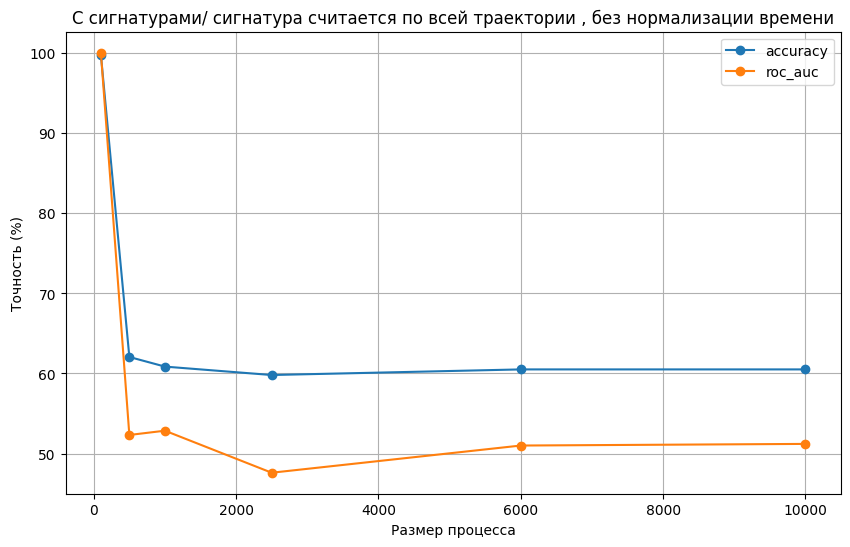

In [50]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=key)
plt.title("С сигнатурами/ сигнатура считается по всей траектории , без нормализации времени")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

С нормализацией временной компоненты


In [51]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [52]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])
    

Размер процесса: 100
Epoch [1/20], Loss: 0.0503, Accuracy: 98.60%, F1-score: 97.64
Epoch [2/20], Loss: 0.0274, Accuracy: 98.90%, F1-score: 98.17
Epoch [3/20], Loss: 0.0007, Accuracy: 99.75%, F1-score: 99.58
Epoch [4/20], Loss: 0.0010, Accuracy: 99.85%, F1-score: 99.75
Epoch [5/20], Loss: 0.0021, Accuracy: 99.95%, F1-score: 99.92
Epoch [6/20], Loss: 0.0001, Accuracy: 99.90%, F1-score: 99.83
Epoch [7/20], Loss: 0.0001, Accuracy: 99.90%, F1-score: 99.83
Epoch [8/20], Loss: 0.0001, Accuracy: 99.90%, F1-score: 99.83
Epoch [9/20], Loss: 0.0001, Accuracy: 99.90%, F1-score: 99.83
Epoch [10/20], Loss: 0.0001, Accuracy: 99.90%, F1-score: 99.83
Epoch [11/20], Loss: 0.0000, Accuracy: 99.90%, F1-score: 99.83
Epoch [12/20], Loss: 0.0000, Accuracy: 99.90%, F1-score: 99.83
Epoch [13/20], Loss: 0.0000, Accuracy: 99.90%, F1-score: 99.83
Epoch [14/20], Loss: 0.0000, Accuracy: 99.90%, F1-score: 99.83
Epoch [15/20], Loss: 0.0000, Accuracy: 99.90%, F1-score: 99.83
Epoch [16/20], Loss: 0.0000, Accuracy: 99.9

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6230, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5497, Accuracy: 69.80%, F1-score: 0.00
Epoch [3/20], Loss: 0.5991, Accuracy: 68.35%, F1-score: 11.96
Epoch [4/20], Loss: 0.5154, Accuracy: 68.85%, F1-score: 6.32
Epoch [5/20], Loss: 0.5207, Accuracy: 65.80%, F1-score: 17.99
Epoch [6/20], Loss: 0.5062, Accuracy: 63.75%, F1-score: 24.56
Epoch [7/20], Loss: 0.5016, Accuracy: 61.55%, F1-score: 25.99
Epoch [8/20], Loss: 0.3379, Accuracy: 61.45%, F1-score: 27.06
Epoch [9/20], Loss: 0.2259, Accuracy: 62.15%, F1-score: 30.49
Epoch [10/20], Loss: 0.1615, Accuracy: 60.90%, F1-score: 28.12
Epoch [11/20], Loss: 0.1324, Accuracy: 59.85%, F1-score: 29.62
Epoch [12/20], Loss: 0.0871, Accuracy: 60.55%, F1-score: 30.73
Epoch [13/20], Loss: 0.1039, Accuracy: 63.10%, F1-score: 28.63
Epoch [14/20], Loss: 0.0367, Accuracy: 62.70%, F1-score: 28.13
Epoch [15/20], Loss: 0.0376, Accuracy: 62.25%, F1-score: 27.05
Epoch [16/20], Loss: 0.0191, Accuracy: 60.40%, F1-score: 30.65
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.7626, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6008, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/20], Loss: 0.5802, Accuracy: 69.35%, F1-score: 6.13
Epoch [4/20], Loss: 0.5020, Accuracy: 67.60%, F1-score: 9.24
Epoch [5/20], Loss: 0.4480, Accuracy: 62.60%, F1-score: 24.90
Epoch [6/20], Loss: 0.4601, Accuracy: 59.90%, F1-score: 25.05
Epoch [7/20], Loss: 0.3077, Accuracy: 59.45%, F1-score: 26.87
Epoch [8/20], Loss: 0.2227, Accuracy: 58.60%, F1-score: 28.13
Epoch [9/20], Loss: 0.0556, Accuracy: 58.45%, F1-score: 27.04
Epoch [10/20], Loss: 0.0489, Accuracy: 62.45%, F1-score: 26.44
Epoch [11/20], Loss: 0.1315, Accuracy: 57.45%, F1-score: 30.76
Epoch [12/20], Loss: 0.1099, Accuracy: 59.15%, F1-score: 25.93
Epoch [13/20], Loss: 0.0598, Accuracy: 57.75%, F1-score: 27.72
Epoch [14/20], Loss: 0.0206, Accuracy: 58.95%, F1-score: 30.25
Epoch [15/20], Loss: 0.0454, Accuracy: 57.80%, F1-score: 28.84
Epoch [16/20], Loss: 0.0640, Accuracy: 59.70%, F1-score: 27.52
Epoch [17/20], Loss: 0.0111, Accuracy: 59.65%, F1-score: 26.03
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6022, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.6293, Accuracy: 69.75%, F1-score: 1.63
Epoch [3/20], Loss: 0.4642, Accuracy: 65.35%, F1-score: 15.38
Epoch [4/20], Loss: 0.4419, Accuracy: 60.20%, F1-score: 26.70
Epoch [5/20], Loss: 0.2506, Accuracy: 61.05%, F1-score: 27.67
Epoch [6/20], Loss: 0.0805, Accuracy: 60.40%, F1-score: 20.96
Epoch [7/20], Loss: 0.1251, Accuracy: 61.30%, F1-score: 26.57
Epoch [8/20], Loss: 0.0091, Accuracy: 61.15%, F1-score: 25.93
Epoch [9/20], Loss: 0.1260, Accuracy: 59.90%, F1-score: 26.15
Epoch [10/20], Loss: 0.3048, Accuracy: 59.70%, F1-score: 28.55
Epoch [11/20], Loss: 0.0091, Accuracy: 58.75%, F1-score: 28.82
Epoch [12/20], Loss: 0.0064, Accuracy: 60.25%, F1-score: 26.73
Epoch [13/20], Loss: 0.0054, Accuracy: 56.25%, F1-score: 28.22
Epoch [14/20], Loss: 0.0798, Accuracy: 59.15%, F1-score: 26.73
Epoch [15/20], Loss: 0.0562, Accuracy: 58.30%, F1-score: 28.10
Epoch [16/20], Loss: 0.0578, Accuracy: 58.45%, F1-score: 30.34
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.4826, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5236, Accuracy: 69.85%, F1-score: 2.58
Epoch [3/20], Loss: 0.4507, Accuracy: 64.50%, F1-score: 20.94
Epoch [4/20], Loss: 0.2507, Accuracy: 59.35%, F1-score: 28.12
Epoch [5/20], Loss: 0.0442, Accuracy: 59.75%, F1-score: 26.62
Epoch [6/20], Loss: 0.2930, Accuracy: 61.70%, F1-score: 24.46
Epoch [7/20], Loss: 0.1341, Accuracy: 59.45%, F1-score: 25.39
Epoch [8/20], Loss: 0.1292, Accuracy: 60.15%, F1-score: 26.95
Epoch [9/20], Loss: 0.0006, Accuracy: 62.50%, F1-score: 24.70
Epoch [10/20], Loss: 0.2098, Accuracy: 61.10%, F1-score: 25.34
Epoch [11/20], Loss: 0.1109, Accuracy: 61.55%, F1-score: 24.24
Epoch [12/20], Loss: 0.0340, Accuracy: 63.10%, F1-score: 26.93
Epoch [13/20], Loss: 0.0153, Accuracy: 58.40%, F1-score: 29.85
Epoch [14/20], Loss: 0.0053, Accuracy: 60.60%, F1-score: 25.38
Epoch [15/20], Loss: 0.0045, Accuracy: 59.15%, F1-score: 26.73
Epoch [16/20], Loss: 0.0027, Accuracy: 60.60%, F1-score: 25.38
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6573, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.4593, Accuracy: 67.20%, F1-score: 10.38
Epoch [3/20], Loss: 0.5726, Accuracy: 58.20%, F1-score: 28.91
Epoch [4/20], Loss: 0.0662, Accuracy: 61.50%, F1-score: 27.77
Epoch [5/20], Loss: 0.1075, Accuracy: 57.95%, F1-score: 31.57
Epoch [6/20], Loss: 0.0089, Accuracy: 61.10%, F1-score: 28.62
Epoch [7/20], Loss: 0.0010, Accuracy: 60.85%, F1-score: 30.03
Epoch [8/20], Loss: 0.1145, Accuracy: 60.00%, F1-score: 27.40
Epoch [9/20], Loss: 0.1245, Accuracy: 60.20%, F1-score: 28.55
Epoch [10/20], Loss: 0.0573, Accuracy: 60.00%, F1-score: 32.09
Epoch [11/20], Loss: 0.0003, Accuracy: 61.95%, F1-score: 23.52
Epoch [12/20], Loss: 0.0271, Accuracy: 61.90%, F1-score: 26.02
Epoch [13/20], Loss: 0.0005, Accuracy: 60.60%, F1-score: 27.31
Epoch [14/20], Loss: 0.0004, Accuracy: 60.85%, F1-score: 27.16
Epoch [15/20], Loss: 0.0001, Accuracy: 61.00%, F1-score: 27.24
Epoch [16/20], Loss: 0.0001, Accuracy: 61.05%, F1-score: 27.26
Ep

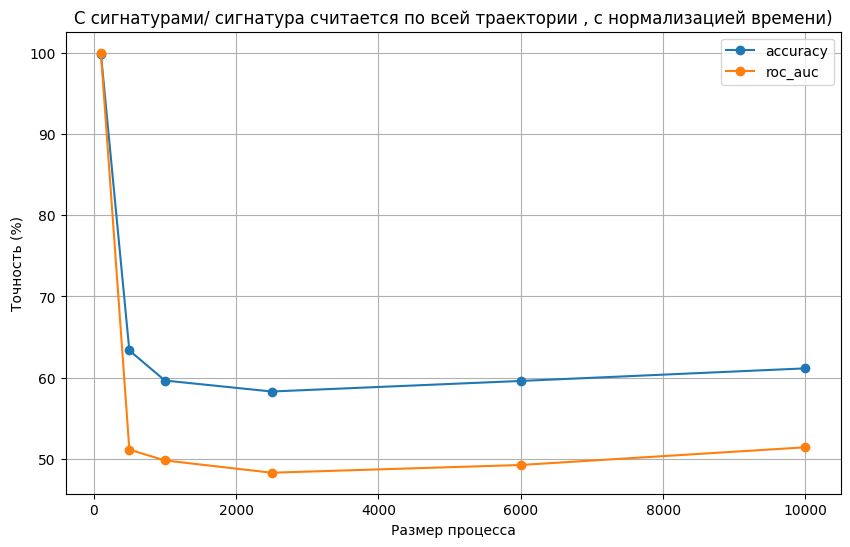

In [54]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=key)
plt.title("С сигнатурами/ сигнатура считается по всей траектории , c нормализацией времени)")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

Заметим, что сигнатура, вычисляемая по всему размеру траектории процесса, не обладает способностью различать процесс с аномалией и без
Также заметим, что с ростом размера траектории процесса способность различать процесс с аномалией и без пропадает и у модели, обучаемой на данных, не обработанных сигнатурой.

Пробуем вычислять сигнатуры на окнах те разбиваем траекторию процесса на равные отрезки считаем на каждом сигнатуру и усредняем
Предполагаем, что такой метод поможет сигнатуре быть более чувствительной к аномалии

In [55]:
def calc_sig_window(window, path, timeline):
    # assert(len(path) % window == 0)
    mean_sig = np.zeros(iisignature.siglength(dimension, level)) 
    for i in range(int(len(path)/window)):
        last_border = (i+1)*window
        if last_border > len(path):
            last_border = len(path)
        mean_sig += iisignature.sig(np.column_stack((timeline[i*window:(i+1)*window], path[i*window:(i+1)*window ])), level)
    mean_sig /= int(len(path)/window)
    return mean_sig

In [56]:
model_params = {
    "n_samples": 10000,
    "n_steps": 500,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [57]:
window = 50

In [58]:
X_noanomaly, timeline = generate_ou_process(int(1), n_steps, mu, theta, sigma, anomaly=0)
print(X_noanomaly.shape)

(1, 500)


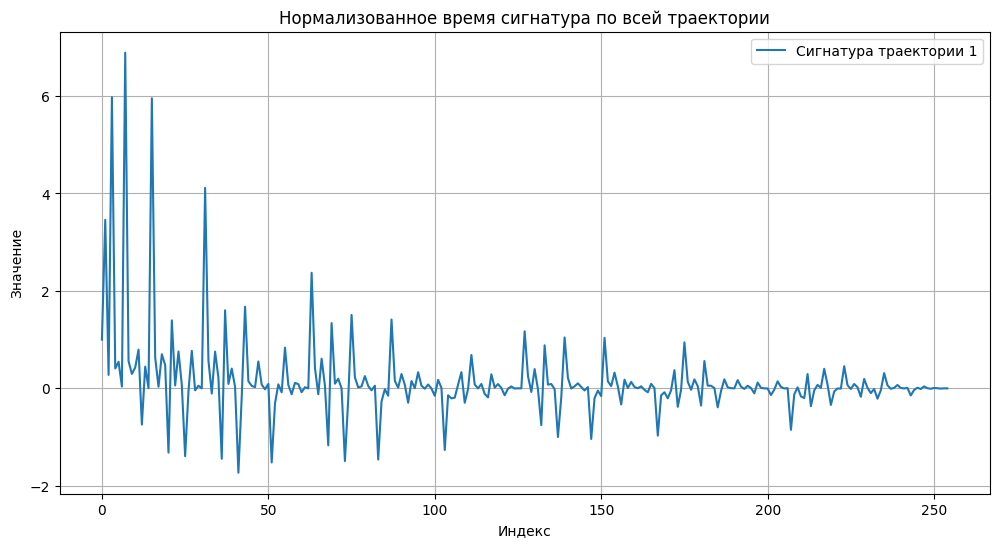

In [59]:
signatures = []
signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[0])), level)
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время сигнатура по всей траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

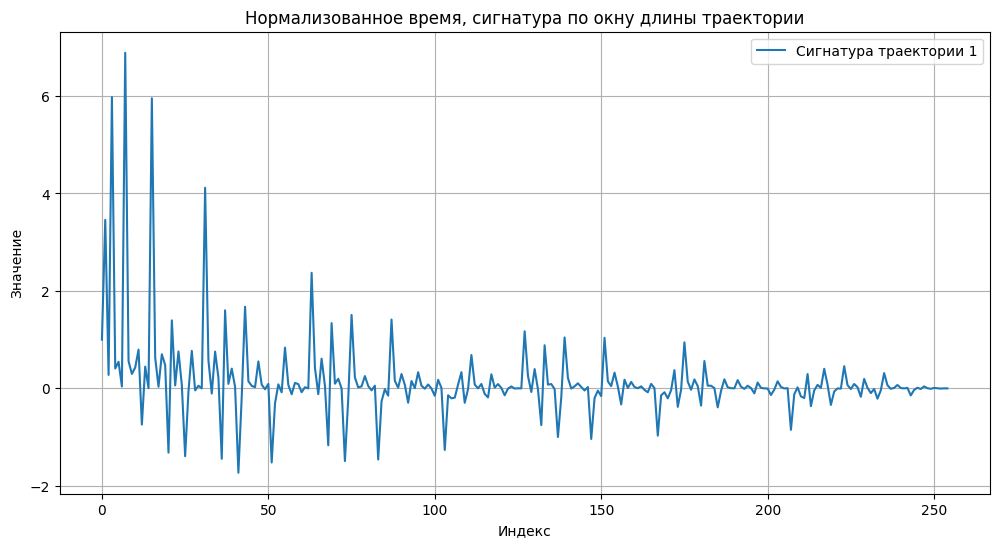

In [60]:
signatures = []
# signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[0])), level)
# signatures.append(signature)
signature = calc_sig_window(n_steps, X_noanomaly[0], normalize_arr(timeline))
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время, сигнатура по окну длины траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

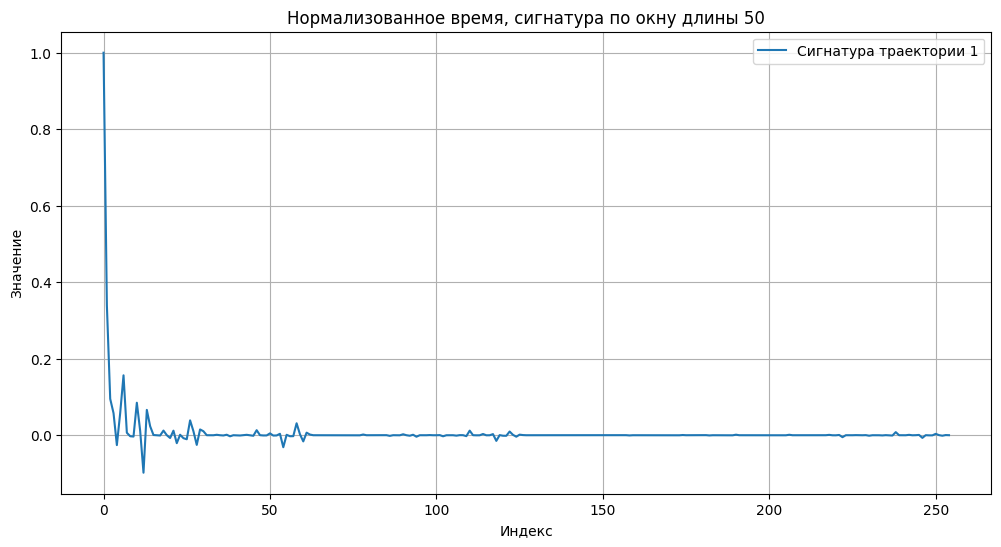

In [61]:
signatures = []
# signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[0])), level)
# signatures.append(signature)
signature = calc_sig_window(window, X_noanomaly[0], normalize_arr(timeline))
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title(f"Нормализованное время, сигнатура по окну длины {window}")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим различные окна

In [62]:
model_params = {
    "n_samples": 10000,
    "n_steps": 2000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Окно не используется тк данные без сигнатур

In [65]:
window_sizes = range(50, 1000, 50)
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for window in window_sizes:
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Окно: {window}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])


Окно: 50


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.7301, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.5364, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.5749, Accuracy: 65.95%, F1-score: 13.69
Epoch [4/25], Loss: 0.5361, Accuracy: 63.55%, F1-score: 26.44
Epoch [5/25], Loss: 0.3455, Accuracy: 58.80%, F1-score: 29.21
Epoch [6/25], Loss: 0.2184, Accuracy: 61.35%, F1-score: 26.73
Epoch [7/25], Loss: 0.1120, Accuracy: 60.50%, F1-score: 32.36
Epoch [8/25], Loss: 0.0678, Accuracy: 61.10%, F1-score: 28.36
Epoch [9/25], Loss: 0.2333, Accuracy: 59.65%, F1-score: 30.85
Epoch [10/25], Loss: 0.0187, Accuracy: 62.15%, F1-score: 25.57
Epoch [11/25], Loss: 0.0111, Accuracy: 58.55%, F1-score: 31.32
Epoch [12/25], Loss: 0.0422, Accuracy: 56.40%, F1-score: 31.45
Epoch [13/25], Loss: 0.0477, Accuracy: 59.50%, F1-score: 30.77
Epoch [14/25], Loss: 0.0057, Accuracy: 60.85%, F1-score: 26.75
Epoch [15/25], Loss: 0.1925, Accuracy: 59.80%, F1-score: 32.32
Epoch [16/25], Loss: 0.0613, Accuracy: 61.25%, F1-score: 29.48
Epoch [17/25], Loss: 0.0029, Accuracy: 61.60%, F1-score: 29.02
E

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6124, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.4817, Accuracy: 70.10%, F1-score: 1.97
Epoch [3/25], Loss: 0.5917, Accuracy: 67.80%, F1-score: 9.80
Epoch [4/25], Loss: 0.4794, Accuracy: 62.95%, F1-score: 26.71
Epoch [5/25], Loss: 0.2010, Accuracy: 59.50%, F1-score: 28.32
Epoch [6/25], Loss: 0.2414, Accuracy: 61.50%, F1-score: 30.51
Epoch [7/25], Loss: 0.1032, Accuracy: 59.45%, F1-score: 23.71
Epoch [8/25], Loss: 0.0090, Accuracy: 61.70%, F1-score: 26.06
Epoch [9/25], Loss: 0.1810, Accuracy: 61.30%, F1-score: 24.41
Epoch [10/25], Loss: 0.0853, Accuracy: 56.70%, F1-score: 29.36
Epoch [11/25], Loss: 0.1128, Accuracy: 55.65%, F1-score: 30.10
Epoch [12/25], Loss: 0.0164, Accuracy: 57.65%, F1-score: 28.76
Epoch [13/25], Loss: 0.0171, Accuracy: 61.10%, F1-score: 29.14
Epoch [14/25], Loss: 0.0060, Accuracy: 60.15%, F1-score: 33.42
Epoch [15/25], Loss: 0.0003, Accuracy: 59.45%, F1-score: 30.15
Epoch [16/25], Loss: 0.0081, Accuracy: 61.50%, F1-score: 28.57
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.5544, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.6193, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.5148, Accuracy: 68.85%, F1-score: 3.41
Epoch [4/25], Loss: 0.3800, Accuracy: 61.35%, F1-score: 29.28
Epoch [5/25], Loss: 0.3615, Accuracy: 57.05%, F1-score: 30.89
Epoch [6/25], Loss: 0.1682, Accuracy: 59.85%, F1-score: 31.78
Epoch [7/25], Loss: 0.1961, Accuracy: 58.40%, F1-score: 35.80
Epoch [8/25], Loss: 0.0499, Accuracy: 63.20%, F1-score: 29.37
Epoch [9/25], Loss: 0.0099, Accuracy: 62.75%, F1-score: 29.12
Epoch [10/25], Loss: 0.0063, Accuracy: 61.10%, F1-score: 29.53
Epoch [11/25], Loss: 0.0445, Accuracy: 61.70%, F1-score: 29.98
Epoch [12/25], Loss: 0.0154, Accuracy: 60.90%, F1-score: 28.78
Epoch [13/25], Loss: 0.0346, Accuracy: 60.65%, F1-score: 28.00
Epoch [14/25], Loss: 0.0022, Accuracy: 57.75%, F1-score: 30.22
Epoch [15/25], Loss: 0.0007, Accuracy: 60.00%, F1-score: 29.70
Epoch [16/25], Loss: 0.0008, Accuracy: 61.00%, F1-score: 29.35
Epoch [17/25], Loss: 0.0003, Accuracy: 60.95%, F1-score: 28.94
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6754, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6749, Accuracy: 70.00%, F1-score: 0.33
Epoch [3/25], Loss: 0.4924, Accuracy: 66.70%, F1-score: 15.05
Epoch [4/25], Loss: 0.3789, Accuracy: 63.25%, F1-score: 24.77
Epoch [5/25], Loss: 0.3589, Accuracy: 60.85%, F1-score: 27.97
Epoch [6/25], Loss: 0.0786, Accuracy: 61.25%, F1-score: 30.49
Epoch [7/25], Loss: 0.0914, Accuracy: 60.25%, F1-score: 26.18
Epoch [8/25], Loss: 0.1135, Accuracy: 59.90%, F1-score: 29.53
Epoch [9/25], Loss: 0.1337, Accuracy: 59.25%, F1-score: 31.22
Epoch [10/25], Loss: 0.1755, Accuracy: 59.00%, F1-score: 30.86
Epoch [11/25], Loss: 0.0379, Accuracy: 60.00%, F1-score: 28.06
Epoch [12/25], Loss: 0.0228, Accuracy: 58.70%, F1-score: 30.82
Epoch [13/25], Loss: 0.0012, Accuracy: 61.70%, F1-score: 26.77
Epoch [14/25], Loss: 0.0005, Accuracy: 60.70%, F1-score: 28.02
Epoch [15/25], Loss: 0.0003, Accuracy: 60.95%, F1-score: 27.48
Epoch [16/25], Loss: 0.0002, Accuracy: 61.10%, F1-score: 27.70
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6219, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.5700, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.5228, Accuracy: 68.35%, F1-score: 4.24
Epoch [4/25], Loss: 0.4145, Accuracy: 62.05%, F1-score: 20.19
Epoch [5/25], Loss: 0.2943, Accuracy: 58.75%, F1-score: 27.57
Epoch [6/25], Loss: 0.2118, Accuracy: 59.80%, F1-score: 26.37
Epoch [7/25], Loss: 0.0445, Accuracy: 58.05%, F1-score: 27.61
Epoch [8/25], Loss: 0.0918, Accuracy: 57.00%, F1-score: 27.85
Epoch [9/25], Loss: 0.1393, Accuracy: 58.45%, F1-score: 26.78
Epoch [10/25], Loss: 0.0218, Accuracy: 58.25%, F1-score: 30.01
Epoch [11/25], Loss: 0.0068, Accuracy: 59.15%, F1-score: 26.86
Epoch [12/25], Loss: 0.0121, Accuracy: 58.40%, F1-score: 26.11
Epoch [13/25], Loss: 0.0005, Accuracy: 57.25%, F1-score: 27.73
Epoch [14/25], Loss: 0.3519, Accuracy: 59.50%, F1-score: 26.50
Epoch [15/25], Loss: 0.3122, Accuracy: 58.65%, F1-score: 25.96
Epoch [16/25], Loss: 0.0096, Accuracy: 57.10%, F1-score: 29.67
Epoch [17/25], Loss: 0.0269, Accuracy: 60.30%, F1-score: 24.95
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.7296, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.5629, Accuracy: 69.45%, F1-score: 4.08
Epoch [3/25], Loss: 0.5364, Accuracy: 65.90%, F1-score: 14.75
Epoch [4/25], Loss: 0.6490, Accuracy: 61.25%, F1-score: 23.65
Epoch [5/25], Loss: 0.2442, Accuracy: 61.85%, F1-score: 25.99
Epoch [6/25], Loss: 0.1057, Accuracy: 57.95%, F1-score: 29.27
Epoch [7/25], Loss: 0.0230, Accuracy: 61.15%, F1-score: 23.45
Epoch [8/25], Loss: 0.1499, Accuracy: 62.20%, F1-score: 24.85
Epoch [9/25], Loss: 0.0104, Accuracy: 61.15%, F1-score: 29.56
Epoch [10/25], Loss: 0.1311, Accuracy: 59.90%, F1-score: 28.65
Epoch [11/25], Loss: 0.0994, Accuracy: 58.80%, F1-score: 30.17
Epoch [12/25], Loss: 0.0680, Accuracy: 59.60%, F1-score: 25.19
Epoch [13/25], Loss: 0.0127, Accuracy: 60.00%, F1-score: 24.95
Epoch [14/25], Loss: 0.0254, Accuracy: 59.30%, F1-score: 24.91
Epoch [15/25], Loss: 0.0017, Accuracy: 58.95%, F1-score: 26.10
Epoch [16/25], Loss: 0.0002, Accuracy: 60.30%, F1-score: 23.65
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.7139, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6646, Accuracy: 69.70%, F1-score: 0.98
Epoch [3/25], Loss: 0.6354, Accuracy: 66.20%, F1-score: 17.36
Epoch [4/25], Loss: 0.5114, Accuracy: 60.90%, F1-score: 26.37
Epoch [5/25], Loss: 0.2494, Accuracy: 61.85%, F1-score: 21.42
Epoch [6/25], Loss: 0.0941, Accuracy: 58.50%, F1-score: 31.06
Epoch [7/25], Loss: 0.3279, Accuracy: 62.10%, F1-score: 25.10
Epoch [8/25], Loss: 0.2248, Accuracy: 61.00%, F1-score: 28.18
Epoch [9/25], Loss: 0.0200, Accuracy: 60.35%, F1-score: 28.62
Epoch [10/25], Loss: 0.0663, Accuracy: 59.40%, F1-score: 30.72
Epoch [11/25], Loss: 0.1058, Accuracy: 59.15%, F1-score: 26.86
Epoch [12/25], Loss: 0.1999, Accuracy: 58.75%, F1-score: 29.67
Epoch [13/25], Loss: 0.0519, Accuracy: 61.00%, F1-score: 26.69
Epoch [14/25], Loss: 0.0024, Accuracy: 60.20%, F1-score: 28.93
Epoch [15/25], Loss: 0.0022, Accuracy: 59.80%, F1-score: 28.34
Epoch [16/25], Loss: 0.1205, Accuracy: 61.80%, F1-score: 25.24
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6493, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6202, Accuracy: 69.70%, F1-score: 1.62
Epoch [3/25], Loss: 0.5280, Accuracy: 66.85%, F1-score: 10.28
Epoch [4/25], Loss: 0.4859, Accuracy: 62.65%, F1-score: 24.32
Epoch [5/25], Loss: 0.3725, Accuracy: 60.15%, F1-score: 26.41
Epoch [6/25], Loss: 0.1272, Accuracy: 58.35%, F1-score: 25.02
Epoch [7/25], Loss: 0.0668, Accuracy: 60.95%, F1-score: 28.68
Epoch [8/25], Loss: 0.0073, Accuracy: 61.40%, F1-score: 26.20
Epoch [9/25], Loss: 0.0647, Accuracy: 60.35%, F1-score: 29.89
Epoch [10/25], Loss: 0.0471, Accuracy: 58.75%, F1-score: 27.70
Epoch [11/25], Loss: 0.0299, Accuracy: 59.05%, F1-score: 26.28
Epoch [12/25], Loss: 0.0996, Accuracy: 58.95%, F1-score: 24.19
Epoch [13/25], Loss: 0.0064, Accuracy: 58.35%, F1-score: 26.35
Epoch [14/25], Loss: 0.0152, Accuracy: 60.10%, F1-score: 23.71
Epoch [15/25], Loss: 0.0800, Accuracy: 62.45%, F1-score: 23.13
Epoch [16/25], Loss: 0.1618, Accuracy: 57.75%, F1-score: 23.67
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6571, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6501, Accuracy: 69.80%, F1-score: 2.27
Epoch [3/25], Loss: 0.6814, Accuracy: 68.25%, F1-score: 5.37
Epoch [4/25], Loss: 0.4296, Accuracy: 63.80%, F1-score: 26.87
Epoch [5/25], Loss: 0.1975, Accuracy: 59.25%, F1-score: 31.11
Epoch [6/25], Loss: 0.1849, Accuracy: 59.95%, F1-score: 29.18
Epoch [7/25], Loss: 0.1457, Accuracy: 56.80%, F1-score: 31.97
Epoch [8/25], Loss: 0.1730, Accuracy: 61.90%, F1-score: 26.87
Epoch [9/25], Loss: 0.1106, Accuracy: 60.40%, F1-score: 28.52
Epoch [10/25], Loss: 0.1436, Accuracy: 59.00%, F1-score: 31.21
Epoch [11/25], Loss: 0.0045, Accuracy: 60.25%, F1-score: 30.93
Epoch [12/25], Loss: 0.0165, Accuracy: 60.85%, F1-score: 28.36
Epoch [13/25], Loss: 0.0415, Accuracy: 58.20%, F1-score: 28.30
Epoch [14/25], Loss: 0.0124, Accuracy: 60.45%, F1-score: 29.06
Epoch [15/25], Loss: 0.0012, Accuracy: 57.45%, F1-score: 29.84
Epoch [16/25], Loss: 0.1199, Accuracy: 58.80%, F1-score: 29.57
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6261, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.7612, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.4614, Accuracy: 69.40%, F1-score: 1.61
Epoch [4/25], Loss: 0.5165, Accuracy: 62.70%, F1-score: 23.57
Epoch [5/25], Loss: 0.2077, Accuracy: 62.40%, F1-score: 30.11
Epoch [6/25], Loss: 0.2034, Accuracy: 61.55%, F1-score: 25.70
Epoch [7/25], Loss: 0.3451, Accuracy: 63.35%, F1-score: 27.06
Epoch [8/25], Loss: 0.1128, Accuracy: 62.60%, F1-score: 26.52
Epoch [9/25], Loss: 0.0940, Accuracy: 61.55%, F1-score: 27.38
Epoch [10/25], Loss: 0.0542, Accuracy: 60.40%, F1-score: 27.34
Epoch [11/25], Loss: 0.0213, Accuracy: 57.60%, F1-score: 28.86
Epoch [12/25], Loss: 0.1021, Accuracy: 59.00%, F1-score: 32.12
Epoch [13/25], Loss: 0.0149, Accuracy: 60.00%, F1-score: 25.51
Epoch [14/25], Loss: 0.0024, Accuracy: 60.95%, F1-score: 29.06
Epoch [15/25], Loss: 0.0295, Accuracy: 61.20%, F1-score: 25.10
Epoch [16/25], Loss: 0.0028, Accuracy: 58.75%, F1-score: 30.14
Epoch [17/25], Loss: 0.0955, Accuracy: 60.15%, F1-score: 29.78
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6013, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.5857, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.4919, Accuracy: 66.25%, F1-score: 18.18
Epoch [4/25], Loss: 0.5144, Accuracy: 63.45%, F1-score: 24.41
Epoch [5/25], Loss: 0.3303, Accuracy: 61.80%, F1-score: 27.10
Epoch [6/25], Loss: 0.3304, Accuracy: 58.15%, F1-score: 30.42
Epoch [7/25], Loss: 0.1596, Accuracy: 59.80%, F1-score: 30.21
Epoch [8/25], Loss: 0.0396, Accuracy: 61.90%, F1-score: 26.45
Epoch [9/25], Loss: 0.0113, Accuracy: 61.40%, F1-score: 27.85
Epoch [10/25], Loss: 0.0156, Accuracy: 60.50%, F1-score: 27.66
Epoch [11/25], Loss: 0.0021, Accuracy: 57.10%, F1-score: 33.90
Epoch [12/25], Loss: 0.1317, Accuracy: 57.90%, F1-score: 31.43
Epoch [13/25], Loss: 0.0933, Accuracy: 58.10%, F1-score: 31.42
Epoch [14/25], Loss: 0.0262, Accuracy: 60.05%, F1-score: 28.21
Epoch [15/25], Loss: 0.0028, Accuracy: 56.60%, F1-score: 31.22
Epoch [16/25], Loss: 0.1894, Accuracy: 59.50%, F1-score: 28.32
Epoch [17/25], Loss: 0.0018, Accuracy: 58.10%, F1-score: 29.22
E

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6237, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.5754, Accuracy: 69.60%, F1-score: 1.94
Epoch [3/25], Loss: 0.4440, Accuracy: 66.55%, F1-score: 11.39
Epoch [4/25], Loss: 0.3723, Accuracy: 64.00%, F1-score: 22.41
Epoch [5/25], Loss: 0.4698, Accuracy: 60.85%, F1-score: 28.88
Epoch [6/25], Loss: 0.2327, Accuracy: 59.45%, F1-score: 30.62
Epoch [7/25], Loss: 0.1518, Accuracy: 58.90%, F1-score: 31.84
Epoch [8/25], Loss: 0.3118, Accuracy: 60.00%, F1-score: 32.55
Epoch [9/25], Loss: 0.0316, Accuracy: 58.50%, F1-score: 33.71
Epoch [10/25], Loss: 0.0401, Accuracy: 60.65%, F1-score: 26.65
Epoch [11/25], Loss: 0.1025, Accuracy: 60.25%, F1-score: 29.71
Epoch [12/25], Loss: 0.0038, Accuracy: 59.55%, F1-score: 31.15
Epoch [13/25], Loss: 0.0384, Accuracy: 58.55%, F1-score: 34.57
Epoch [14/25], Loss: 0.0507, Accuracy: 60.05%, F1-score: 28.72
Epoch [15/25], Loss: 0.0008, Accuracy: 59.30%, F1-score: 32.95
Epoch [16/25], Loss: 0.0010, Accuracy: 59.25%, F1-score: 30.87
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6900, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6125, Accuracy: 69.85%, F1-score: 0.00
Epoch [3/25], Loss: 0.4689, Accuracy: 67.80%, F1-score: 11.29
Epoch [4/25], Loss: 0.4233, Accuracy: 66.60%, F1-score: 17.94
Epoch [5/25], Loss: 0.4263, Accuracy: 60.05%, F1-score: 29.23
Epoch [6/25], Loss: 0.2132, Accuracy: 63.40%, F1-score: 22.62
Epoch [7/25], Loss: 0.1716, Accuracy: 59.90%, F1-score: 27.62
Epoch [8/25], Loss: 0.0243, Accuracy: 60.90%, F1-score: 26.78
Epoch [9/25], Loss: 0.0678, Accuracy: 61.95%, F1-score: 27.32
Epoch [10/25], Loss: 0.1210, Accuracy: 62.50%, F1-score: 30.56
Epoch [11/25], Loss: 0.2992, Accuracy: 57.20%, F1-score: 32.81
Epoch [12/25], Loss: 0.0538, Accuracy: 62.25%, F1-score: 27.47
Epoch [13/25], Loss: 0.0107, Accuracy: 56.90%, F1-score: 31.91
Epoch [14/25], Loss: 0.0085, Accuracy: 60.70%, F1-score: 31.41
Epoch [15/25], Loss: 0.0011, Accuracy: 61.35%, F1-score: 28.36
Epoch [16/25], Loss: 0.0003, Accuracy: 61.00%, F1-score: 28.18
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.7121, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.5765, Accuracy: 69.95%, F1-score: 0.33
Epoch [3/25], Loss: 0.5530, Accuracy: 68.20%, F1-score: 10.67
Epoch [4/25], Loss: 0.2329, Accuracy: 63.70%, F1-score: 20.74
Epoch [5/25], Loss: 0.4289, Accuracy: 56.00%, F1-score: 30.60
Epoch [6/25], Loss: 0.1598, Accuracy: 61.40%, F1-score: 23.11
Epoch [7/25], Loss: 0.2043, Accuracy: 61.30%, F1-score: 27.66
Epoch [8/25], Loss: 0.1493, Accuracy: 58.45%, F1-score: 27.55
Epoch [9/25], Loss: 0.1825, Accuracy: 58.90%, F1-score: 22.16
Epoch [10/25], Loss: 0.0708, Accuracy: 60.90%, F1-score: 26.37
Epoch [11/25], Loss: 0.2399, Accuracy: 58.55%, F1-score: 26.05
Epoch [12/25], Loss: 0.0713, Accuracy: 58.10%, F1-score: 27.13
Epoch [13/25], Loss: 0.0686, Accuracy: 57.95%, F1-score: 26.81
Epoch [14/25], Loss: 0.0033, Accuracy: 58.90%, F1-score: 27.00
Epoch [15/25], Loss: 0.0048, Accuracy: 58.20%, F1-score: 24.68
Epoch [16/25], Loss: 0.0337, Accuracy: 57.40%, F1-score: 29.70
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.5132, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6030, Accuracy: 69.95%, F1-score: 0.00
Epoch [3/25], Loss: 0.5617, Accuracy: 67.85%, F1-score: 15.73
Epoch [4/25], Loss: 0.4298, Accuracy: 63.60%, F1-score: 22.88
Epoch [5/25], Loss: 0.1760, Accuracy: 58.45%, F1-score: 25.34
Epoch [6/25], Loss: 0.1844, Accuracy: 59.75%, F1-score: 26.08
Epoch [7/25], Loss: 0.1377, Accuracy: 59.80%, F1-score: 26.78
Epoch [8/25], Loss: 0.0436, Accuracy: 61.45%, F1-score: 26.64
Epoch [9/25], Loss: 0.0868, Accuracy: 60.75%, F1-score: 26.57
Epoch [10/25], Loss: 0.0614, Accuracy: 59.45%, F1-score: 24.42
Epoch [11/25], Loss: 0.0026, Accuracy: 59.10%, F1-score: 25.91
Epoch [12/25], Loss: 0.0645, Accuracy: 60.65%, F1-score: 25.82
Epoch [13/25], Loss: 0.0027, Accuracy: 59.95%, F1-score: 24.08
Epoch [14/25], Loss: 0.0035, Accuracy: 60.30%, F1-score: 24.81
Epoch [15/25], Loss: 0.1654, Accuracy: 60.55%, F1-score: 25.07
Epoch [16/25], Loss: 0.0180, Accuracy: 59.35%, F1-score: 28.12
Epo

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.5712, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.5791, Accuracy: 70.05%, F1-score: 0.66
Epoch [3/25], Loss: 0.5040, Accuracy: 68.40%, F1-score: 3.07
Epoch [4/25], Loss: 0.4578, Accuracy: 63.45%, F1-score: 23.62
Epoch [5/25], Loss: 0.3574, Accuracy: 58.70%, F1-score: 28.30
Epoch [6/25], Loss: 0.1558, Accuracy: 59.75%, F1-score: 31.84
Epoch [7/25], Loss: 0.0519, Accuracy: 62.10%, F1-score: 25.69
Epoch [8/25], Loss: 0.0792, Accuracy: 59.65%, F1-score: 26.17
Epoch [9/25], Loss: 0.1039, Accuracy: 61.00%, F1-score: 29.73
Epoch [10/25], Loss: 0.0082, Accuracy: 61.10%, F1-score: 24.90
Epoch [11/25], Loss: 0.0898, Accuracy: 60.55%, F1-score: 28.34
Epoch [12/25], Loss: 0.0283, Accuracy: 60.10%, F1-score: 29.13
Epoch [13/25], Loss: 0.0070, Accuracy: 62.55%, F1-score: 23.80
Epoch [14/25], Loss: 0.0016, Accuracy: 59.40%, F1-score: 30.00
Epoch [15/25], Loss: 0.0426, Accuracy: 59.00%, F1-score: 30.86
Epoch [16/25], Loss: 0.0944, Accuracy: 58.25%, F1-score: 29.54
Epoc

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.5825, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.6285, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.5436, Accuracy: 67.90%, F1-score: 11.81
Epoch [4/25], Loss: 0.4407, Accuracy: 64.90%, F1-score: 23.70
Epoch [5/25], Loss: 0.4895, Accuracy: 59.40%, F1-score: 31.19
Epoch [6/25], Loss: 0.3034, Accuracy: 60.75%, F1-score: 24.59
Epoch [7/25], Loss: 0.0792, Accuracy: 55.60%, F1-score: 35.47
Epoch [8/25], Loss: 0.0681, Accuracy: 61.65%, F1-score: 28.38
Epoch [9/25], Loss: 0.0349, Accuracy: 59.40%, F1-score: 30.24
Epoch [10/25], Loss: 0.0107, Accuracy: 59.15%, F1-score: 32.98
Epoch [11/25], Loss: 0.0636, Accuracy: 60.40%, F1-score: 31.25
Epoch [12/25], Loss: 0.0413, Accuracy: 58.35%, F1-score: 33.31
Epoch [13/25], Loss: 0.1500, Accuracy: 62.85%, F1-score: 28.07
Epoch [14/25], Loss: 0.0868, Accuracy: 58.95%, F1-score: 30.25
Epoch [15/25], Loss: 0.0374, Accuracy: 59.65%, F1-score: 30.13
Epoch [16/25], Loss: 0.0143, Accuracy: 58.85%, F1-score: 32.93
Epoch [17/25], Loss: 0.0110, Accuracy: 58.85%, F1-score: 28.50
E

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6629, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/25], Loss: 0.5567, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/25], Loss: 0.6656, Accuracy: 66.55%, F1-score: 9.96
Epoch [4/25], Loss: 0.4194, Accuracy: 61.65%, F1-score: 21.65
Epoch [5/25], Loss: 0.5347, Accuracy: 56.85%, F1-score: 30.01
Epoch [6/25], Loss: 0.1617, Accuracy: 59.55%, F1-score: 23.32
Epoch [7/25], Loss: 0.1556, Accuracy: 57.10%, F1-score: 26.92
Epoch [8/25], Loss: 0.1429, Accuracy: 58.60%, F1-score: 26.33
Epoch [9/25], Loss: 0.0338, Accuracy: 57.00%, F1-score: 25.48
Epoch [10/25], Loss: 0.0992, Accuracy: 59.00%, F1-score: 29.31
Epoch [11/25], Loss: 0.3331, Accuracy: 59.90%, F1-score: 27.49
Epoch [12/25], Loss: 0.0329, Accuracy: 61.15%, F1-score: 23.15
Epoch [13/25], Loss: 0.0184, Accuracy: 58.75%, F1-score: 27.82
Epoch [14/25], Loss: 0.1677, Accuracy: 59.15%, F1-score: 24.42
Epoch [15/25], Loss: 0.0277, Accuracy: 57.25%, F1-score: 27.36
Epoch [16/25], Loss: 0.1302, Accuracy: 59.45%, F1-score: 25.80
Epoch [17/25], Loss: 0.0005, Accuracy: 58.60%, F1-score: 27.37
Ep

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Loss: 0.6652, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/25], Loss: 0.6190, Accuracy: 69.90%, F1-score: 0.00
Epoch [3/25], Loss: 0.7425, Accuracy: 68.65%, F1-score: 7.66
Epoch [4/25], Loss: 0.3888, Accuracy: 63.80%, F1-score: 19.91
Epoch [5/25], Loss: 0.2913, Accuracy: 62.35%, F1-score: 22.93
Epoch [6/25], Loss: 0.2079, Accuracy: 62.55%, F1-score: 25.62
Epoch [7/25], Loss: 0.0803, Accuracy: 58.95%, F1-score: 25.97
Epoch [8/25], Loss: 0.0362, Accuracy: 60.25%, F1-score: 23.92
Epoch [9/25], Loss: 0.0042, Accuracy: 62.95%, F1-score: 22.25
Epoch [10/25], Loss: 0.0351, Accuracy: 58.65%, F1-score: 26.62
Epoch [11/25], Loss: 0.0401, Accuracy: 59.40%, F1-score: 25.91
Epoch [12/25], Loss: 0.0197, Accuracy: 56.20%, F1-score: 29.70
Epoch [13/25], Loss: 0.1648, Accuracy: 58.20%, F1-score: 28.79
Epoch [14/25], Loss: 0.0305, Accuracy: 60.25%, F1-score: 23.78
Epoch [15/25], Loss: 0.0109, Accuracy: 59.95%, F1-score: 23.93
Epoch [16/25], Loss: 0.0009, Accuracy: 59.25%, F1-score: 25.02
Epoc

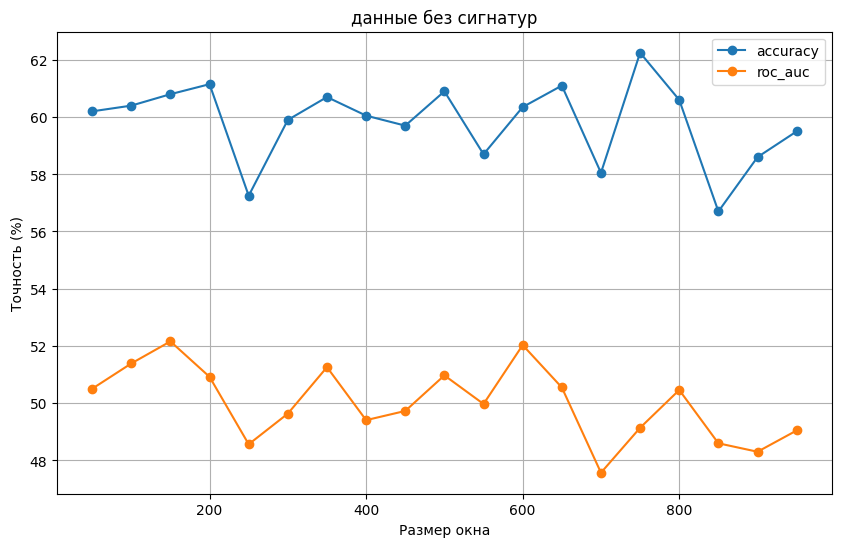

In [66]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(window_sizes, arr, marker='o', label=key)
plt.title("данные без сигнатур")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим сигнатуры по окнам

In [67]:
model_params = {
    "n_samples": 10000,
    "n_steps": 2000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [69]:
window_sizes = range(50, 1000, 50)
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for window in window_sizes:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = calc_sig_window(window, X_noanomaly[i], normalize_arr(timeline))
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = calc_sig_window(window, X_anomaly[i], normalize_arr(timeline))
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])

Окно: 50
Epoch [1/20], Loss: 0.5645, Accuracy: 78.75%, F1-score: 45.72
Epoch [2/20], Loss: 0.2056, Accuracy: 85.80%, F1-score: 79.54
Epoch [3/20], Loss: 0.1120, Accuracy: 91.65%, F1-score: 84.52
Epoch [4/20], Loss: 0.1156, Accuracy: 93.35%, F1-score: 88.28
Epoch [5/20], Loss: 0.3029, Accuracy: 93.30%, F1-score: 87.80
Epoch [6/20], Loss: 0.2164, Accuracy: 93.90%, F1-score: 89.05
Epoch [7/20], Loss: 0.0294, Accuracy: 94.20%, F1-score: 89.59
Epoch [8/20], Loss: 0.2968, Accuracy: 93.70%, F1-score: 88.48
Epoch [9/20], Loss: 0.2458, Accuracy: 95.40%, F1-score: 92.03
Epoch [10/20], Loss: 0.0207, Accuracy: 94.90%, F1-score: 90.96
Epoch [11/20], Loss: 0.1482, Accuracy: 95.70%, F1-score: 92.80
Epoch [12/20], Loss: 0.1774, Accuracy: 95.50%, F1-score: 92.19
Epoch [13/20], Loss: 0.2983, Accuracy: 96.20%, F1-score: 93.53
Epoch [14/20], Loss: 0.1338, Accuracy: 95.30%, F1-score: 91.67
Epoch [15/20], Loss: 0.0519, Accuracy: 95.40%, F1-score: 92.26
Epoch [16/20], Loss: 0.1848, Accuracy: 94.90%, F1-score

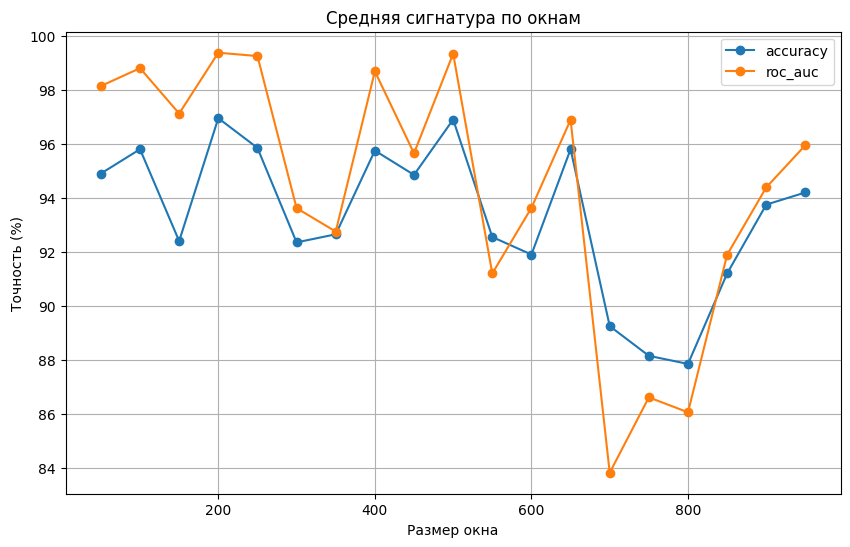

In [70]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(window_sizes, arr, marker='o', label=key)
plt.title("Cредняя сигнатура по окнам")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим большие окна

Графики показывают, что метод усреднения сигнатур по окнам позволяет лучше отличать процесс с аномалией и без

Поиск окна, где модель теряет способность отличать аномалии

In [71]:
window_sizes = range(int(n_steps/2), n_steps + 1, 100)
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for window in window_sizes:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = calc_sig_window(window, X_noanomaly[i], normalize_arr(timeline))
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = calc_sig_window(window, X_anomaly[i], normalize_arr(timeline))
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])


Окно: 1000
Epoch [1/20], Loss: 0.2379, Accuracy: 92.50%, F1-score: 87.37
Epoch [2/20], Loss: 0.2220, Accuracy: 94.05%, F1-score: 90.24
Epoch [3/20], Loss: 0.0716, Accuracy: 95.00%, F1-score: 91.47
Epoch [4/20], Loss: 0.1124, Accuracy: 94.70%, F1-score: 90.57
Epoch [5/20], Loss: 0.1323, Accuracy: 95.60%, F1-score: 92.28
Epoch [6/20], Loss: 0.1159, Accuracy: 96.40%, F1-score: 94.00
Epoch [7/20], Loss: 0.1747, Accuracy: 94.50%, F1-score: 91.20
Epoch [8/20], Loss: 0.2076, Accuracy: 96.55%, F1-score: 94.19
Epoch [9/20], Loss: 0.0304, Accuracy: 96.90%, F1-score: 94.76
Epoch [10/20], Loss: 0.1054, Accuracy: 95.60%, F1-score: 92.48
Epoch [11/20], Loss: 0.2496, Accuracy: 96.65%, F1-score: 94.40
Epoch [12/20], Loss: 0.0148, Accuracy: 95.70%, F1-score: 92.35
Epoch [13/20], Loss: 0.1433, Accuracy: 96.50%, F1-score: 93.88
Epoch [14/20], Loss: 0.0906, Accuracy: 96.55%, F1-score: 94.30
Epoch [15/20], Loss: 0.0824, Accuracy: 96.55%, F1-score: 94.08
Epoch [16/20], Loss: 0.0929, Accuracy: 97.10%, F1-sco

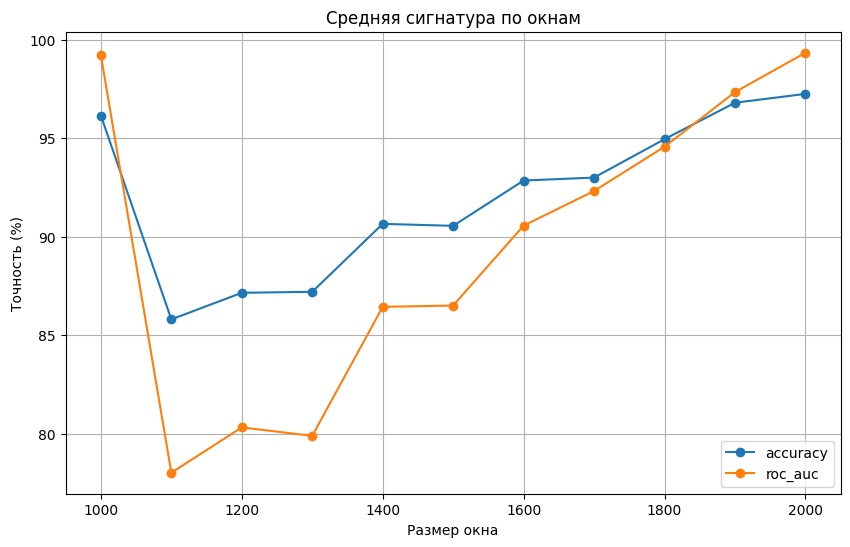

In [72]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(window_sizes, arr, marker='o', label=key)
plt.title("Cредняя сигнатура по окнам")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим линейный стационарный процесс

In [73]:
model_params = {
    "n_samples": 10000,
    "n_steps": 2000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [74]:
window_sizes = range(50, 500, 50)
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for window in window_sizes:
    X_noanomaly, _ = generate_linear_func(int(n_samples * 0.7), n_steps)
    X_anomaly, _ = generate_linear_func(int(n_samples * 0.3), n_steps, anomaly=True)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])

Окно: 50


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6807, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6869, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.5950, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.6474, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5004, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.7310, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.5695, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.5968, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.5732, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.6470, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.6733, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6974, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.5714, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.5945, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.6229, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.5471, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.6706, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.7298, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 5, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 49.95%
Окно: 100


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6272, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.4382, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5439, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5943, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.5954, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.5967, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.6699, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6998, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6949, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.5226, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.5454, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.5943, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.6706, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 2, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 50.02%
Окно: 150


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5674, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5467, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.6768, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5393, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6230, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.7220, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.6735, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.6514, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.5101, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5681, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.7668, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.5946, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.5387, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6218, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.5428, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.6778, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.6931, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.5949, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.6192, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 9, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 49.85%
Окно: 200


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5675, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5675, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.6493, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.6510, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6729, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.5944, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.5934, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6220, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5666, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.5963, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.5706, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6450, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.5402, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6218, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.6489, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.4027, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.5084, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.6214, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.5688, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 17, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 49.98%
Окно: 250


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5972, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5350, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.6523, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5395, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5241, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.5127, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.5716, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.7234, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.4886, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.6220, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.7211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.5143, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.5947, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6700, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.6684, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.5113, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.5948, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.5673, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.6465, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 9, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 50.01%
Окно: 300


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5395, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5655, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.7094, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.6480, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5698, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.5742, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.5951, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6490, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5783, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6256, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6220, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.6226, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.5943, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.5943, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.6211, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.4930, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.6741, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 19, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 50.12%
Окно: 350


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.7235, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5040, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.6514, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5967, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6225, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.6492, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.4350, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.5682, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5416, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.5712, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.5946, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6218, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.5960, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.5334, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.5969, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.5725, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.6461, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.6729, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 8, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 50.29%
Окно: 400


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6710, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5156, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.5944, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.7272, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6748, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.5947, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.6502, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.6213, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6220, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5948, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6773, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.5676, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6707, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.4934, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.5452, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.5705, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.4944, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.6215, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/20], Loss: 0.5642, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 14, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 49.88%
Окно: 450


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6755, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6485, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.5966, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5523, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5160, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.5688, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.5729, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.5421, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/20], Loss: 0.5948, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/20], Loss: 0.6541, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/20], Loss: 0.5695, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.6212, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/20], Loss: 0.7040, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/20], Loss: 0.6743, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/20], Loss: 0.6786, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.6827, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/20], Loss: 0.5455, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/20], Loss: 0.5417, Accuracy: 70.00%, F1-score: 0.00
Epoch [20/20], Loss: 0.5948, Accuracy: 70.00%, F1-score: 0.00
Минимум функции потерь на эпохе 5, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%, F1-score: 0.00%, Roc-auc: 50.26%


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


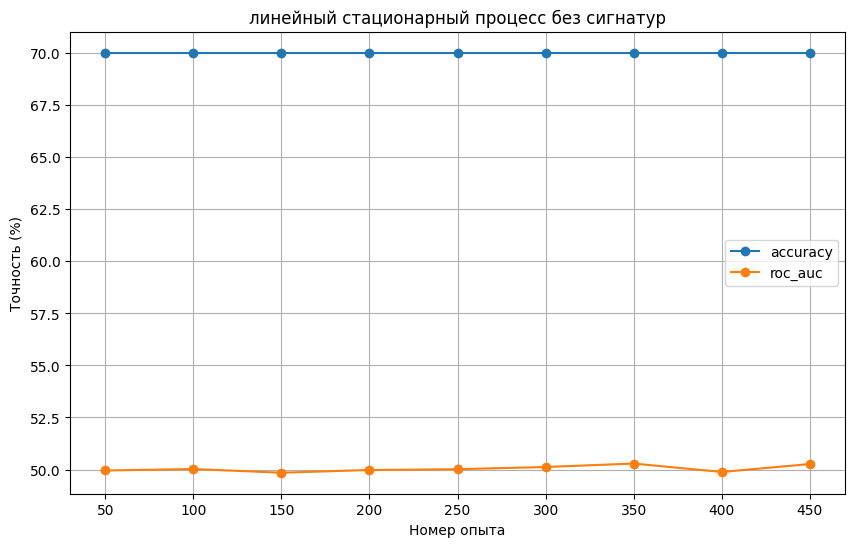

In [75]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(window_sizes, arr, marker='o', label=key)
plt.title("линейный стационарный процесс без сигнатур")
plt.xlabel("Номер опыта")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

С сигнатурой

In [76]:
window_sizes = range(50, 500, 50)
metrics_dict = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
}

for window in window_sizes:
    X_noanomaly, timeline = generate_linear_func(int(n_samples * 0.7), n_steps)
    X_anomaly, timeline = generate_linear_func(int(n_samples * 0.3), n_steps, anomaly=True)

    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = calc_sig_window(window, X_noanomaly[i], normalize_arr(timeline))
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = calc_sig_window(window, X_anomaly[i], normalize_arr(timeline))
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    metrics = train_nn(model_params, X, y)
    metrics_dict["accuracy"].append(metrics["accuracy"])
    metrics_dict["precision"].append(metrics["precision"])
    metrics_dict["recall"].append(metrics["recall"])
    metrics_dict["f1_score"].append(metrics["f1_score"])
    metrics_dict["roc_auc"].append(metrics["roc_auc"])

Окно: 50
Epoch [1/20], Loss: 0.6191, Accuracy: 70.05%, F1-score: 0.33
Epoch [2/20], Loss: 0.6731, Accuracy: 70.05%, F1-score: 0.33
Epoch [3/20], Loss: 0.5567, Accuracy: 70.15%, F1-score: 1.00
Epoch [4/20], Loss: 0.5716, Accuracy: 70.15%, F1-score: 1.00
Epoch [5/20], Loss: 0.6476, Accuracy: 70.15%, F1-score: 1.00
Epoch [6/20], Loss: 0.6613, Accuracy: 70.20%, F1-score: 1.32
Epoch [7/20], Loss: 0.6473, Accuracy: 70.20%, F1-score: 1.32
Epoch [8/20], Loss: 0.6019, Accuracy: 70.20%, F1-score: 1.32
Epoch [9/20], Loss: 0.6927, Accuracy: 69.35%, F1-score: 3.77
Epoch [10/20], Loss: 0.6163, Accuracy: 70.15%, F1-score: 1.00
Epoch [11/20], Loss: 0.6813, Accuracy: 70.20%, F1-score: 1.32
Epoch [12/20], Loss: 0.6290, Accuracy: 70.20%, F1-score: 1.32
Epoch [13/20], Loss: 0.6351, Accuracy: 70.25%, F1-score: 1.65
Epoch [14/20], Loss: 0.6226, Accuracy: 70.05%, F1-score: 0.33
Epoch [15/20], Loss: 0.5179, Accuracy: 70.10%, F1-score: 0.66
Epoch [16/20], Loss: 0.5395, Accuracy: 70.15%, F1-score: 1.00
Epoch [1

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6255, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.6546, Accuracy: 70.05%, F1-score: 0.33
Epoch [3/20], Loss: 0.6201, Accuracy: 70.05%, F1-score: 0.33
Epoch [4/20], Loss: 0.7475, Accuracy: 70.05%, F1-score: 0.33
Epoch [5/20], Loss: 0.6464, Accuracy: 70.05%, F1-score: 0.33
Epoch [6/20], Loss: 0.6176, Accuracy: 70.05%, F1-score: 0.33
Epoch [7/20], Loss: 0.5977, Accuracy: 70.05%, F1-score: 0.33
Epoch [8/20], Loss: 0.5441, Accuracy: 70.05%, F1-score: 0.33
Epoch [9/20], Loss: 0.6445, Accuracy: 74.95%, F1-score: 28.33
Epoch [10/20], Loss: 0.6168, Accuracy: 72.20%, F1-score: 13.66
Epoch [11/20], Loss: 0.6144, Accuracy: 70.20%, F1-score: 1.32
Epoch [12/20], Loss: 0.5789, Accuracy: 71.05%, F1-score: 6.76
Epoch [13/20], Loss: 0.5776, Accuracy: 71.10%, F1-score: 7.07
Epoch [14/20], Loss: 0.4912, Accuracy: 76.15%, F1-score: 34.02
Epoch [15/20], Loss: 0.5257, Accuracy: 75.55%, F1-score: 31.22
Epoch [16/20], Loss: 0.5172, Accuracy: 66.40%, F1-score: 45.10
Epoch [17/20

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5410, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5710, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.5483, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5595, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6195, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6420, Accuracy: 70.00%, F1-score: 0.00
Epoch [7/20], Loss: 0.6926, Accuracy: 70.10%, F1-score: 0.66
Epoch [8/20], Loss: 0.6098, Accuracy: 71.00%, F1-score: 6.45
Epoch [9/20], Loss: 0.5620, Accuracy: 70.85%, F1-score: 5.51
Epoch [10/20], Loss: 0.5131, Accuracy: 75.80%, F1-score: 32.40
Epoch [11/20], Loss: 0.5327, Accuracy: 73.45%, F1-score: 20.63
Epoch [12/20], Loss: 0.7376, Accuracy: 75.30%, F1-score: 30.03
Epoch [13/20], Loss: 0.6407, Accuracy: 73.65%, F1-score: 21.69
Epoch [14/20], Loss: 0.6750, Accuracy: 70.80%, F1-score: 5.19
Epoch [15/20], Loss: 0.4057, Accuracy: 74.60%, F1-score: 26.59
Epoch [16/20], Loss: 0.6508, Accuracy: 71.15%, F1-score: 7.38
Epoch [17/20], Loss: 0.3995, Accuracy: 71.30%, F1-score: 46.65
Epoch [18/20], Loss: 0.4912, Accuracy: 76.20%, F1-score: 34.25
Epoch [19/20], Loss: 0.5780, Accuracy: 72.55%, F1-score: 15.67
Epoch [20/20], Loss: 0.7826, Accuracy: 71.65%, F1-score: 10.43
Минимум функции потерь на эпохе 17, Accuracy: 71.30%, Precision: 

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5998, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5702, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.7688, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.6252, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.5950, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6152, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.6885, Accuracy: 70.00%, F1-score: 0.00
Epoch [8/20], Loss: 0.6596, Accuracy: 70.75%, F1-score: 4.88


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.6619, Accuracy: 70.00%, F1-score: 0.00
Epoch [10/20], Loss: 0.6642, Accuracy: 73.25%, F1-score: 19.55
Epoch [11/20], Loss: 0.7532, Accuracy: 71.55%, F1-score: 9.83
Epoch [12/20], Loss: 0.5355, Accuracy: 72.80%, F1-score: 17.07
Epoch [13/20], Loss: 0.5970, Accuracy: 75.40%, F1-score: 30.51
Epoch [14/20], Loss: 0.3391, Accuracy: 74.55%, F1-score: 26.34
Epoch [15/20], Loss: 0.6615, Accuracy: 72.65%, F1-score: 16.23
Epoch [16/20], Loss: 0.5260, Accuracy: 77.05%, F1-score: 38.06
Epoch [17/20], Loss: 0.4890, Accuracy: 76.85%, F1-score: 37.18
Epoch [18/20], Loss: 0.3489, Accuracy: 77.25%, F1-score: 38.93
Epoch [19/20], Loss: 0.5535, Accuracy: 73.90%, F1-score: 23.01
Epoch [20/20], Loss: 0.3659, Accuracy: 78.15%, F1-score: 42.73
Минимум функции потерь на эпохе 14, Accuracy: 74.55%, Precision: 100.00%, Recall: 15.17%, F1-score: 26.34%, Roc-auc: 70.10%
Окно: 300
Epoch [1/20], Loss: 0.7099, Accuracy: 70.05%, F1-score: 0.33
Epoch [2/20], Loss: 0.7184, Accuracy: 70.05%, F1-sco

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/20], Loss: 0.5221, Accuracy: 70.00%, F1-score: 0.00
Epoch [10/20], Loss: 0.4216, Accuracy: 75.75%, F1-score: 32.17
Epoch [11/20], Loss: 0.6616, Accuracy: 70.30%, F1-score: 1.98
Epoch [12/20], Loss: 0.4632, Accuracy: 76.75%, F1-score: 36.73
Epoch [13/20], Loss: 0.3678, Accuracy: 75.10%, F1-score: 29.06
Epoch [14/20], Loss: 0.5829, Accuracy: 74.95%, F1-score: 28.33
Epoch [15/20], Loss: 0.4507, Accuracy: 70.75%, F1-score: 4.88
Epoch [16/20], Loss: 0.6358, Accuracy: 70.10%, F1-score: 0.66
Epoch [17/20], Loss: 0.6659, Accuracy: 70.10%, F1-score: 0.66
Epoch [18/20], Loss: 0.5522, Accuracy: 71.00%, F1-score: 6.45
Epoch [19/20], Loss: 0.4521, Accuracy: 71.80%, F1-score: 11.32
Epoch [20/20], Loss: 0.6320, Accuracy: 75.70%, F1-score: 31.93
Минимум функции потерь на эпохе 13, Accuracy: 75.10%, Precision: 100.00%, Recall: 17.00%, F1-score: 29.06%, Roc-auc: 64.09%
Окно: 350


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6659, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.6755, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/20], Loss: 0.5547, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5929, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/20], Loss: 0.6326, Accuracy: 70.00%, F1-score: 0.00
Epoch [6/20], Loss: 0.5024, Accuracy: 70.05%, F1-score: 0.33
Epoch [7/20], Loss: 0.6254, Accuracy: 72.80%, F1-score: 17.07
Epoch [8/20], Loss: 0.4978, Accuracy: 74.40%, F1-score: 25.58
Epoch [9/20], Loss: 0.4782, Accuracy: 72.85%, F1-score: 17.35
Epoch [10/20], Loss: 0.7729, Accuracy: 72.30%, F1-score: 14.24
Epoch [11/20], Loss: 0.5244, Accuracy: 73.75%, F1-score: 22.22
Epoch [12/20], Loss: 0.5333, Accuracy: 74.20%, F1-score: 24.56
Epoch [13/20], Loss: 0.5473, Accuracy: 77.90%, F1-score: 41.69
Epoch [14/20], Loss: 0.4356, Accuracy: 76.75%, F1-score: 36.73
Epoch [15/20], Loss: 0.4679, Accuracy: 75.60%, F1-score: 31.46
Epoch [16/20], Loss: 0.5409, Accuracy: 76.50%, F1-score: 35.62
Epoch [17/20], Loss: 0.5075, Accuracy: 73.90%, F1-score: 46.07
Epoch [18/20], Loss: 0.5598, Accuracy: 58.50%, F1-score: 44.22
Epoch [19/20], Loss: 0.4375, Accuracy: 77.85%, F1-score: 41.48
Epoch [20/20], Loss: 0.6989, Accuracy: 74.50%, F1-score: 26.09

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.6884, Accuracy: 70.00%, F1-score: 0.00
Epoch [2/20], Loss: 0.5726, Accuracy: 70.05%, F1-score: 0.33
Epoch [3/20], Loss: 0.4878, Accuracy: 70.05%, F1-score: 0.33
Epoch [4/20], Loss: 0.6278, Accuracy: 70.05%, F1-score: 0.33
Epoch [5/20], Loss: 0.5970, Accuracy: 70.05%, F1-score: 0.33
Epoch [6/20], Loss: 0.5921, Accuracy: 70.25%, F1-score: 1.65
Epoch [7/20], Loss: 0.4673, Accuracy: 70.80%, F1-score: 5.19
Epoch [8/20], Loss: 0.7117, Accuracy: 71.45%, F1-score: 9.22
Epoch [9/20], Loss: 0.5780, Accuracy: 74.95%, F1-score: 28.33
Epoch [10/20], Loss: 0.6443, Accuracy: 73.90%, F1-score: 23.01
Epoch [11/20], Loss: 0.5912, Accuracy: 73.10%, F1-score: 18.73
Epoch [12/20], Loss: 0.5245, Accuracy: 73.50%, F1-score: 20.90
Epoch [13/20], Loss: 0.4650, Accuracy: 76.80%, F1-score: 36.96
Epoch [14/20], Loss: 0.4847, Accuracy: 78.20%, F1-score: 42.93
Epoch [15/20], Loss: 0.6049, Accuracy: 78.30%, F1-score: 43.34
Epoch [16/20], Loss: 0.3697, Accuracy: 78.20%, F1-score: 42.93
Epoch [17

/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/20], Loss: 0.5911, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/20], Loss: 0.5231, Accuracy: 70.00%, F1-score: 0.00
Epoch [3/20], Loss: 0.6220, Accuracy: 70.15%, F1-score: 1.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/20], Loss: 0.5554, Accuracy: 70.00%, F1-score: 0.00
Epoch [5/20], Loss: 0.5449, Accuracy: 71.80%, F1-score: 11.32


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/20], Loss: 0.6157, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/20], Loss: 0.4974, Accuracy: 70.00%, F1-score: 0.00


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/20], Loss: 0.4643, Accuracy: 70.00%, F1-score: 0.00
Epoch [9/20], Loss: 0.5126, Accuracy: 73.35%, F1-score: 20.09
Epoch [10/20], Loss: 0.6446, Accuracy: 71.25%, F1-score: 8.00
Epoch [11/20], Loss: 0.4730, Accuracy: 71.05%, F1-score: 6.76
Epoch [12/20], Loss: 0.4697, Accuracy: 73.65%, F1-score: 21.69


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/20], Loss: 0.5751, Accuracy: 70.00%, F1-score: 0.00
Epoch [14/20], Loss: 0.4141, Accuracy: 78.15%, F1-score: 42.73
Epoch [15/20], Loss: 0.5135, Accuracy: 75.10%, F1-score: 29.06
Epoch [16/20], Loss: 0.7288, Accuracy: 75.75%, F1-score: 32.17


/home/daniel/mipt/anomaly_prediction/myenv_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/20], Loss: 0.7493, Accuracy: 70.00%, F1-score: 0.00
Epoch [18/20], Loss: 0.5612, Accuracy: 73.45%, F1-score: 20.63
Epoch [19/20], Loss: 0.5722, Accuracy: 74.35%, F1-score: 25.33
Epoch [20/20], Loss: 0.3943, Accuracy: 73.85%, F1-score: 22.75
Минимум функции потерь на эпохе 20, Accuracy: 73.85%, Precision: 100.00%, Recall: 12.83%, F1-score: 22.75%, Roc-auc: 69.01%


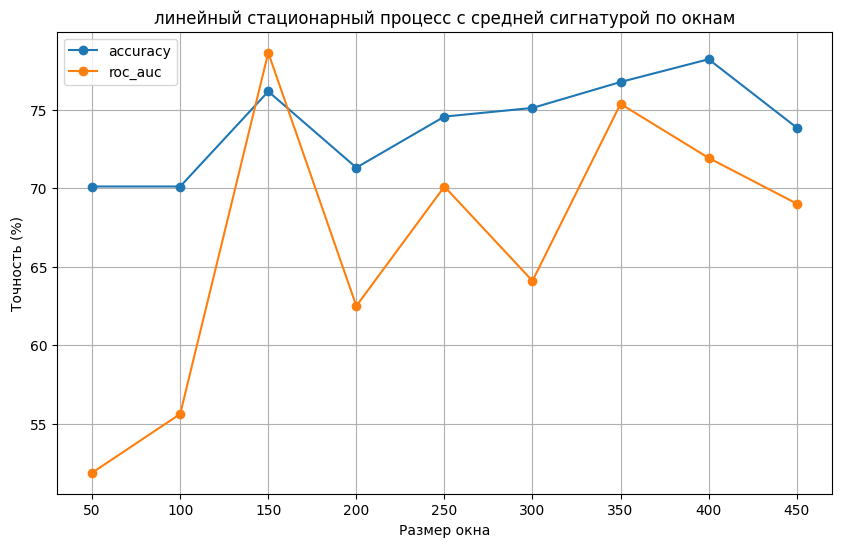

In [77]:
plt.figure(figsize=(10, 6))
for key, arr in metrics_dict.items():
    if key in ["accuracy", "roc_auc"]:
        plt.plot(window_sizes, arr, marker='o', label=key)
plt.title("линейный стационарный процесс с средней сигнатурой по окнам")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()